In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from medpy.metric import dc, assd
import torch.nn.functional as F
import torchio as tio
import nibabel as nib

In [2]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
import torch.nn.functional as F

class BrainSegmentationDataset(Dataset):
    def __init__(self, t1c_dir, t2f_dir, seg_dir, transforms=None):
        self.t1c_dir = t1c_dir
        self.t2f_dir = t2f_dir
        self.seg_dir = seg_dir
        self.transforms = transforms

        # Create a list of all seg images (patient + slice)
        self.seg_files = [os.path.join(root, file) for root, _, files in os.walk(seg_dir) 
                          for file in files if os.path.getsize(os.path.join(root, file)) > 141]

    def __len__(self):
        return len(self.seg_files)

    def __getitem__(self, idx):
        seg_img_path = self.seg_files[idx]
        
        mask = Image.open(seg_img_path).convert('L')
        
        mask = np.array(mask, dtype = np.int64)
        
        background_mask = (mask == 0).astype(np.float32)
        class1_mask = (mask == 85).astype(np.float32)
        class2_mask = (mask == 170).astype(np.float32)
        class3_mask = (mask == 255).astype(np.float32)
        
        mask = np.dstack([background_mask, class1_mask, class2_mask, class3_mask])
        mask = np.argmax(mask, axis = 2)
        
        # Corresponding input images
        t1c_img_path = seg_img_path.replace('seg', 't1c')
        t1c_img = Image.open(t1c_img_path).convert('L')  # load and convert t1c image
        t1c_tensor = torch.from_numpy(np.array(t1c_img,dtype = np.float32)[None, ...])/255.0
#         t1c_tensor = self.transforms(t1c_img)  # transform to tensor

        t2f_img_path = seg_img_path.replace('seg', 't2f')
        t2f_img = Image.open(t2f_img_path)  # load and convert t2f image
        t2f_tensor = torch.from_numpy(np.array(t2f_img,dtype = np.float32)[None, ...])/255.0
#         t2f_tensor = self.transforms(t2f_img)  # transform to tensor

        # Stack t1c and t2f tensors along the channel dimension
        inputs = torch.cat((t1c_tensor, t2f_tensor), dim=0)

        return inputs, mask


In [3]:
from torchvision import transforms

data_transforms = transforms.Compose([
     # You can modify this as per your model's input size
    transforms.ToTensor(),
])

dataset = BrainSegmentationDataset(t1c_dir="BraTS_2023_train/t1cSliced", t2f_dir="BraTS_2023_train/t2fSliced", seg_dir="BraTS_2023_train/segSliced", transforms=data_transforms)


In [4]:
from torch.utils.data import DataLoader, random_split

# Split dataset into training set and validation set
train_size = int(0.8 * len(dataset))  # 80% for training
val_size = len(dataset) - train_size  # 20% for validation
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create a DataLoader for both sets
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)


In [5]:
print(len(train_dataset))
print(len(train_loader))
data, labels = next(iter(train_loader))
print("Data shape:", data.shape)
print("Labels shape:", labels.shape)
data, labels = next(iter(val_loader))
print("Data shape:", data.shape)
print("Labels shape:", labels.shape)


63531
3971
Data shape: torch.Size([16, 2, 256, 256])
Labels shape: torch.Size([16, 256, 256])
Data shape: torch.Size([16, 2, 256, 256])
Labels shape: torch.Size([16, 256, 256])


In [6]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        # Downsample path
        self.conv1 = self.double_conv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = self.double_conv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = self.double_conv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.conv4 = self.double_conv(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        # Bottom
        self.conv5 = self.double_conv(512, 1024)

        # Upsample path
        self.up6 = nn.ConvTranspose2d(1024, 512, kernel_size = 2, stride = 2)
        self.conv6 = self.double_conv(1024, 512)
        self.up7 = nn.ConvTranspose2d(512, 256, kernel_size = 2, stride = 2)
        self.conv7 = self.double_conv(512, 256)
        self.up8 = nn.ConvTranspose2d(256, 128, kernel_size = 2, stride = 2)
        self.conv8 = self.double_conv(256, 128)
        self.up9 = nn.ConvTranspose2d(128, 64, kernel_size = 2, stride = 2)
        self.conv9 = self.double_conv(128, 64)

        # Output
        self.conv10 = nn.Conv2d(64, out_channels, kernel_size = 1)

    def double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.Conv2d(out_channels, out_channels, kernel_size = 3, padding = 1),
            nn.ReLU(inplace = True)
        )

    def forward(self, x):
        # Downsample path
        c1 = self.conv1(x)
        p1 = self.pool1(c1)
        c2 = self.conv2(p1)
        p2 = self.pool2(c2)
        c3 = self.conv3(p2)
        p3 = self.pool3(c3)
        c4 = self.conv4(p3)
        p4 = self.pool4(c4)

        # Bottom
        c5 = self.conv5(p4)

        # Upsample path
        up6 = self.up6(c5)
        merge6 = torch.cat([up6, c4], dim = 1)
        c6 = self.conv6(merge6)
        up7 = self.up7(c6)
        merge7 = torch.cat([up7, c3], dim = 1)
        c7 = self.conv7(merge7)
        up8 = self.up8(c7)
        merge8 = torch.cat([up8, c2], dim = 1)
        c8 = self.conv8(merge8)
        up9 = self.up9(c8)
        merge9 = torch.cat([up9, c1], dim = 1)
        c9 = self.conv9(merge9)

        # Output
        out = self.conv10(c9)
        return out
    
    def predict(self, x):
        out = self.forward(x)
        _, preds = torch.max(out, 1)
        return preds

In [7]:
def plot_preds_and_masks(preds, masks):
    fig, axs = plt.subplots(2, 2, figsize=(10,10))
    for i, (pred, mask) in enumerate(zip(preds, masks)):
#         pred = torch.argmax(pred, dim=0)  # Convert from one-hot encoding to class labels
#         mask = torch.argmax(mask, dim=0)  # Convert from one-hot encoding to class labels

        axs[0, i].imshow(pred.cpu().detach().numpy(), cmap = 'gray')
        axs[0, i].title.set_text("Predicted")
        axs[1, i].imshow(mask.cpu().detach().numpy(), cmap = 'gray')
        axs[1, i].title.set_text("Ground Truth")
    plt.show()


In [8]:
def compute_metrics(pred, target):
    assert pred.shape == target.shape
    batch_size, num_classes, _, _ = pred.shape
    DSCs = []
    ASSDs = []
    for image_idx in range(batch_size):
        dsc_per_class = []
        assd_per_class = []
        for class_idx in range(num_classes):
            pred_class = pred[image_idx, class_idx]
            target_class = target[image_idx, class_idx]

            # Check if the prediction and the target contain any objects
            pred_has_object = np.count_nonzero(pred_class) > 0
            target_has_object = np.count_nonzero(target_class) > 0
            
            if pred_has_object and target_has_object:
                dsc = dc(pred_class, target_class)
                assd_val = assd(pred_class, target_class)
            elif not pred_has_object and not target_has_object:
                dsc = 1.0  # perfect similarity
                assd_val = 0.0  # no distance
            else:
                dsc = 0.0  # no overlap
                assd_val = 362  # maximum distance

            dsc_per_class.append(dsc)
            assd_per_class.append(assd_val)
        
        DSCs.append(dsc_per_class)
        ASSDs.append(assd_per_class)
    DSCs = np.array(DSCs)
    ASSDs = np.array(ASSDs)
        
    return np.mean(DSCs, axis = 0), np.mean(ASSDs, axis = 0)

In [9]:
from tqdm import tqdm
def train_model(num_epochs):
    # Create dataset and dataloader for T1
#     training_dataset_T1 = train_loader
#     validation_dataset_T1 = val_loader

    training_dataloader_T1 = train_loader
    validation_dataloader_T1 = val_loader

    # Check if saved model exists, if so load it, otherwise initialize a new one
    model_path = "unet_model.pth"
    if os.path.isfile(model_path):
        print("Loading model...")
        model = UNet(in_channels = 2, out_channels = 4)
        model.load_state_dict(torch.load(model_path))
        model = model.to(device)
        print("Model loaded.")
    else:
        print("Initializing new model...")
        model = UNet(in_channels = 2, out_channels = 4).to(device)
        print("New model initialized.")

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr = 0.0001)

    for epoch in range(num_epochs):
        print(f"Epoch { epoch + 1 }/{ num_epochs }")
        print("-------------------------")

        # Initialize the running loss to zero
        running_loss = 0.0

        # Initialize counter for the number of batches
        num_batches = 0

        # Initialize the running DSC and ASSD
        running_train_dsc = []
        running_train_assd = []

        # Training phase
        model.train() 
        for i, (images, masks) in enumerate(tqdm(training_dataloader_T1)):
            images = images.to(device)
            masks = masks.to(device)
#             masks = masks.float().squeeze(1).permute(0, 3, 2, 1)

            # Forward pass
            outputs = model(images)
            
            loss = criterion(outputs, masks)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if epoch % 1 == 0 and i == 0:
                print("Training Prediction Visualization:")
                _, preds = torch.max(outputs[:2], 1)
#                 print(outputs.shape,masks.shape)
                plot_preds_and_masks(preds,masks[:2])

            # Update the running loss and batch count
            running_loss += loss.item()
            num_batches += 1


            if epoch % 1 == 0:
                _, preds = torch.max(outputs, 1)
                preds_one_hot = F.one_hot(preds, num_classes = 4)
                preds_one_hot = preds_one_hot.permute(0, 3, 1, 2)

                masks_one_hot = F.one_hot(masks, num_classes = 4)
                masks_one_hot = masks_one_hot.permute(0, 3, 1, 2)

                train_dsc, train_assd = compute_metrics(preds_one_hot.cpu().numpy(), masks_one_hot.cpu().numpy())
                running_train_dsc.append(train_dsc)
                running_train_assd.append(train_assd)


        # Compute and print the average training loss for this epoch
        avg_train_loss = running_loss / num_batches
        print(f"\nAverage Training Loss: {avg_train_loss}")

        if epoch % 1 == 0:
            print(f"\nAverage Training DSC: {np.mean(np.array(running_train_dsc), axis = 0)}\nAverage Training ASSD: {np.mean(np.array(running_train_assd), axis = 0)}")

        # Validation phase
        model.eval()  # Set model to evaluate mode
        running_val_loss = 0.0
        num_val_batches = 0
        running_val_dsc = []
        running_val_assd = []

        with torch.no_grad():  # No need to track gradients in validation phase
            for i, (val_images, val_masks) in enumerate(tqdm(validation_dataloader_T1)):
                val_images = val_images.to(device)
                val_masks = val_masks.to(device)

                val_outputs = model(val_images)
                val_loss = criterion(val_outputs, val_masks)
                
                running_val_loss += val_loss.item()
                num_val_batches += 1


                if epoch % 1 == 0 and i == 0:
                    print("Validation Prediction Visualization:")
                    _, preds = torch.max(val_outputs[:2], 1)
                    
                    plot_preds_and_masks(preds, val_masks[:2])


                if epoch % 1 == 0:
                    _, val_preds = torch.max(val_outputs, 1)
                    val_preds_one_hot = F.one_hot(val_preds, num_classes = 4)
                    val_preds_one_hot = val_preds_one_hot.permute(0, 3, 1, 2)

                    val_masks_one_hot = F.one_hot(val_masks, num_classes = 4)
                    val_masks_one_hot = val_masks_one_hot.permute(0, 3, 1, 2)
                    
                    val_dsc, val_assd = compute_metrics(val_preds_one_hot.cpu().numpy(), val_masks_one_hot.cpu().numpy())
                    running_val_dsc.append(val_dsc)
                    running_val_assd.append(val_assd)

        # Compute and print the average validation loss for this epoch
        avg_val_loss = running_val_loss / num_val_batches
        print(f"Average Validation Loss: {avg_val_loss}")

        if epoch % 1 == 0:
            print(f"\nAverage Validation DSC: {np.mean(np.array(running_val_dsc), axis = 0)}\nAverage Validation ASSD: {np.mean(np.array(running_val_assd), axis = 0)}")

        # Save the trained model
        torch.save(model.state_dict(), "unet_model.pth")

    
    return model

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Initializing new model...
New model initialized.
Epoch 1/50
-------------------------


  0%|          | 0/3971 [00:00<?, ?it/s]

Training Prediction Visualization:


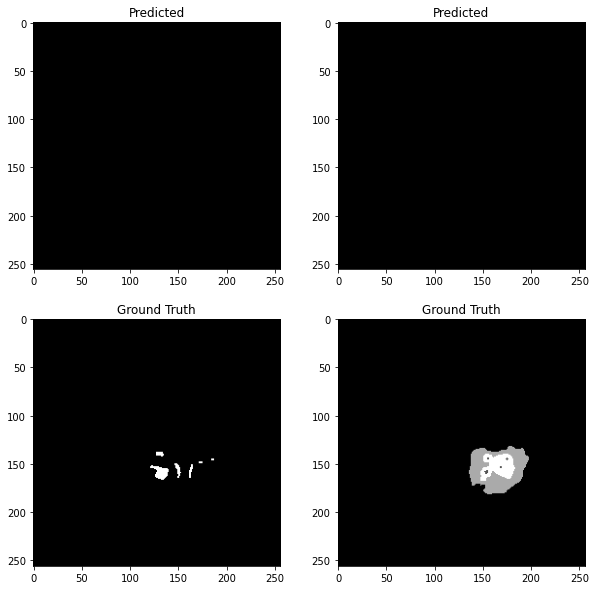

100%|██████████| 3971/3971 [32:32<00:00,  2.03it/s]



Average Training Loss: 0.04586901062045521

Average Training DSC: [0.9913936  0.6055683  0.48439002 0.41873446]
Average Training ASSD: [  2.67757476 100.9270101  111.90145428  91.61493452]


  0%|          | 0/993 [00:00<?, ?it/s]

Validation Prediction Visualization:


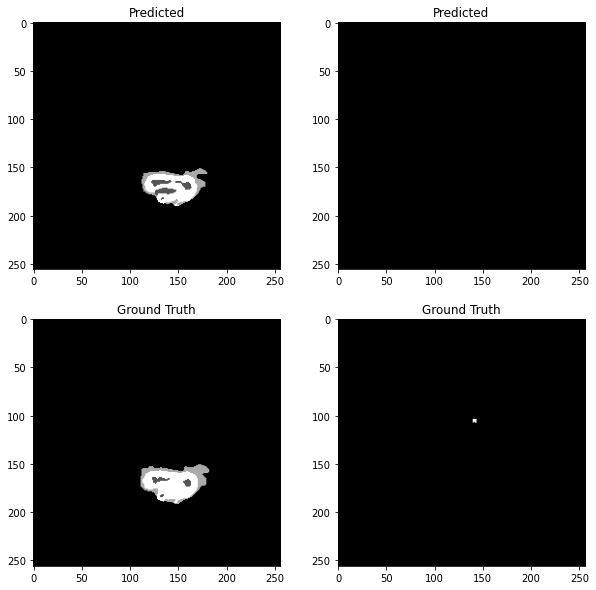

100%|██████████| 993/993 [05:31<00:00,  2.99it/s]


Average Validation Loss: 0.022909730225463828

Average Validation DSC: [0.9973756  0.74384464 0.69986525 0.6159739 ]
Average Validation ASSD: [ 0.59523844 44.24291402 45.49645678 34.89449926]
Epoch 2/50
-------------------------


  0%|          | 0/3971 [00:00<?, ?it/s]

Training Prediction Visualization:


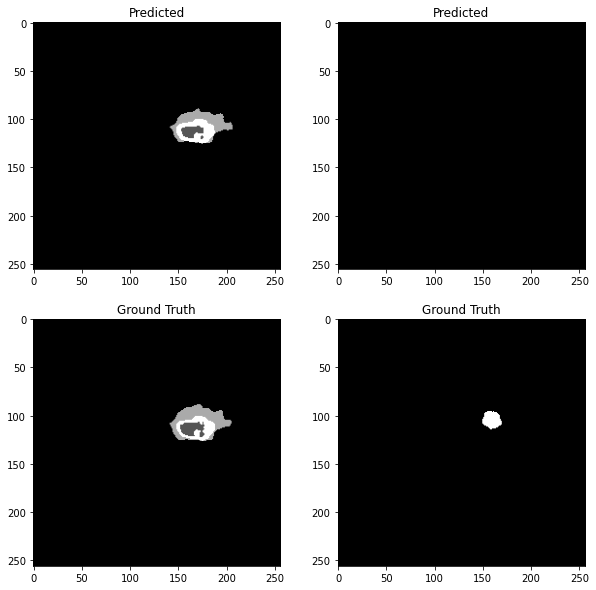

100%|██████████| 3971/3971 [33:05<00:00,  2.00it/s]



Average Training Loss: 0.019980139735578606

Average Training DSC: [0.99772093 0.75990764 0.71754142 0.65494514]
Average Training ASSD: [ 0.49101837 40.31147135 45.43205887 28.32272949]


  0%|          | 0/993 [00:00<?, ?it/s]

Validation Prediction Visualization:


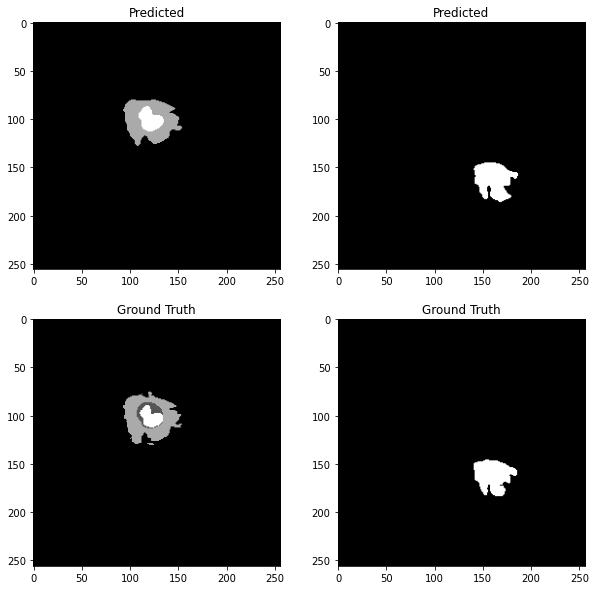

100%|██████████| 993/993 [05:36<00:00,  2.95it/s]


Average Validation Loss: 0.018116167339440978

Average Validation DSC: [0.99800064 0.75605996 0.76124192 0.6772295 ]
Average Validation ASSD: [ 0.40499636 40.73465119 33.34863479 25.13259727]
Epoch 3/50
-------------------------


  0%|          | 0/3971 [00:00<?, ?it/s]

Training Prediction Visualization:


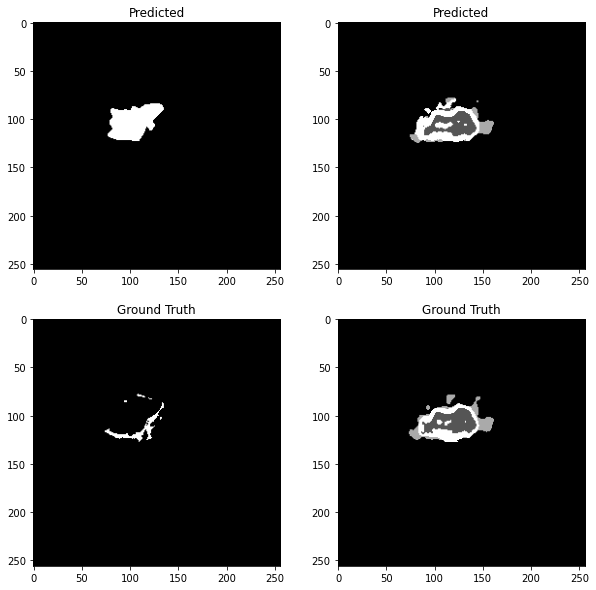

100%|██████████| 3971/3971 [33:43<00:00,  1.96it/s]



Average Training Loss: 0.015303102130193692

Average Training DSC: [0.9981679  0.80174251 0.78046131 0.70575694]
Average Training ASSD: [ 0.37147943 33.14814732 33.13308084 23.55438325]


  0%|          | 0/993 [00:00<?, ?it/s]

Validation Prediction Visualization:


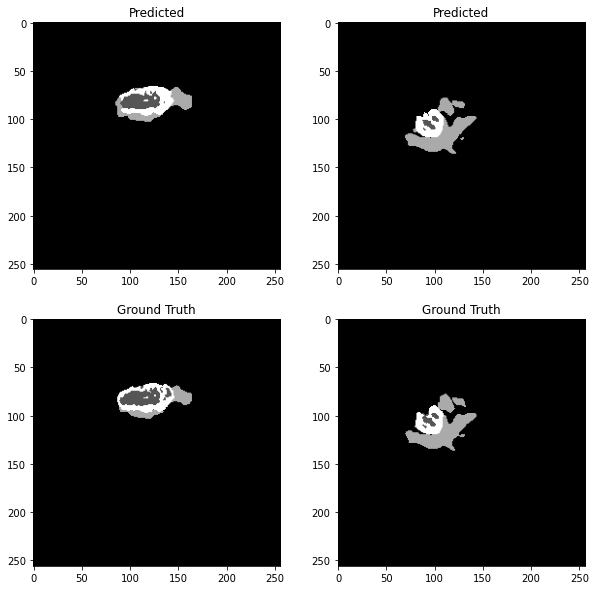

100%|██████████| 993/993 [05:36<00:00,  2.95it/s]


Average Validation Loss: 0.015329390317801863

Average Validation DSC: [0.99819264 0.82045949 0.81303665 0.72502858]
Average Validation ASSD: [ 0.34730351 30.72257766 24.0342782  13.45893821]
Epoch 4/50
-------------------------


  0%|          | 0/3971 [00:00<?, ?it/s]

Training Prediction Visualization:


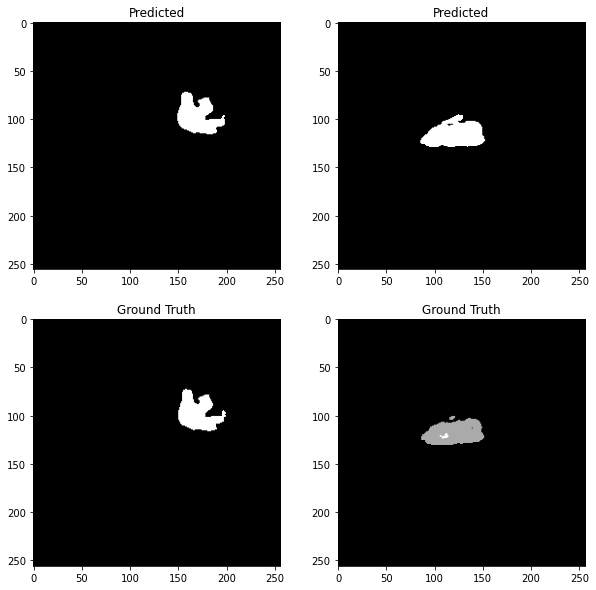

100%|██████████| 3971/3971 [33:45<00:00,  1.96it/s]



Average Training Loss: 0.012489584650425932

Average Training DSC: [0.99846312 0.82541663 0.8171855  0.73797164]
Average Training ASSD: [ 0.29710379 28.59916779 25.72228223 21.11990852]


  0%|          | 0/993 [00:00<?, ?it/s]

Validation Prediction Visualization:


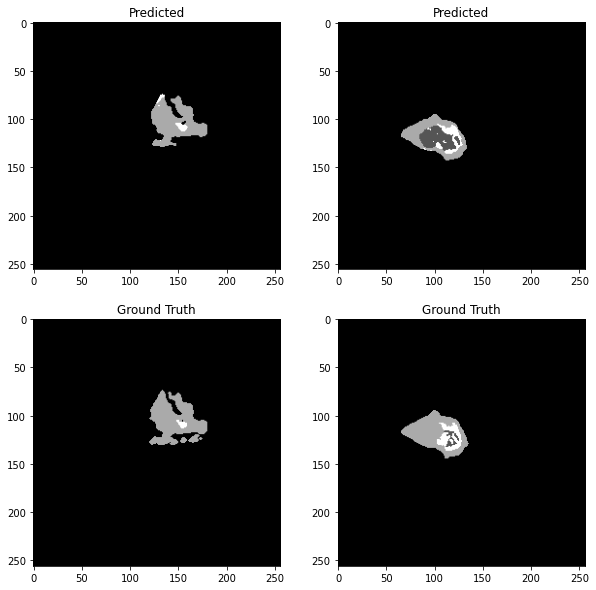

100%|██████████| 993/993 [05:37<00:00,  2.94it/s]


Average Validation Loss: 0.01215352006969375

Average Validation DSC: [0.99853084 0.83093493 0.834795   0.7457996 ]
Average Validation ASSD: [ 0.27732693 27.8564841  20.09033531 19.97760821]
Epoch 5/50
-------------------------


  0%|          | 0/3971 [00:00<?, ?it/s]

Training Prediction Visualization:


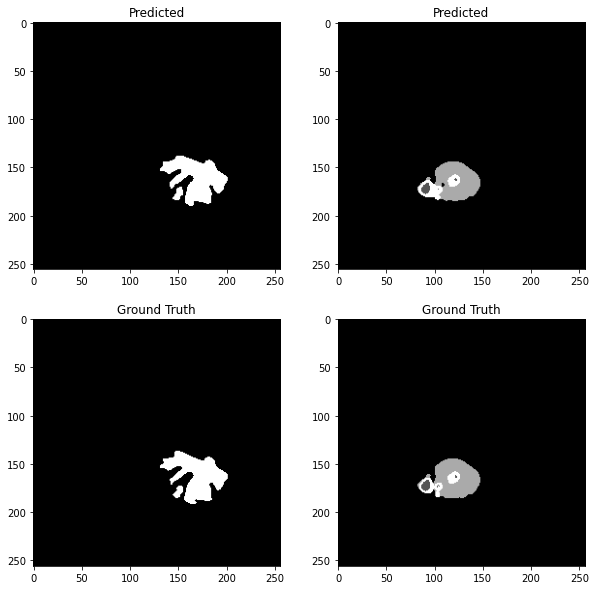

100%|██████████| 3971/3971 [34:05<00:00,  1.94it/s]



Average Training Loss: 0.010648947910367466

Average Training DSC: [0.99866411 0.83943214 0.84147818 0.76189608]
Average Training ASSD: [ 0.24470869 26.29400255 21.33200987 19.21904167]


  0%|          | 0/993 [00:00<?, ?it/s]

Validation Prediction Visualization:


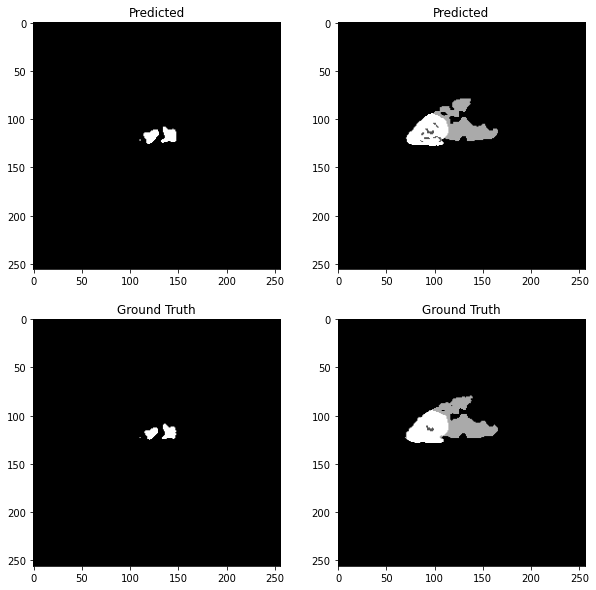

100%|██████████| 993/993 [05:37<00:00,  2.94it/s]


Average Validation Loss: 0.010358502161252985

Average Validation DSC: [0.99870892 0.8476997  0.84966251 0.77082272]
Average Validation ASSD: [ 0.22679626 24.66003035 20.19038789 16.58951344]
Epoch 6/50
-------------------------


  0%|          | 0/3971 [00:00<?, ?it/s]

Training Prediction Visualization:


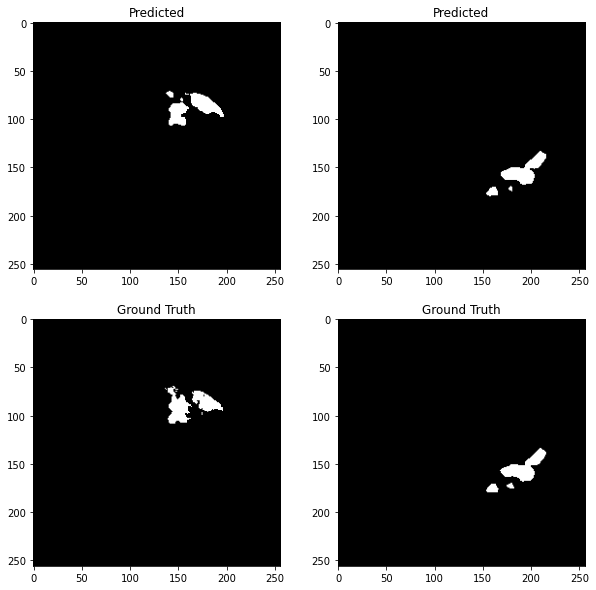

100%|██████████| 3971/3971 [33:44<00:00,  1.96it/s]



Average Training Loss: 0.00937279642533086

Average Training DSC: [0.99879993 0.85176134 0.85973231 0.77965635]
Average Training ASSD: [ 0.20849331 23.48971478 17.89756199 17.63703323]


  0%|          | 0/993 [00:00<?, ?it/s]

Validation Prediction Visualization:


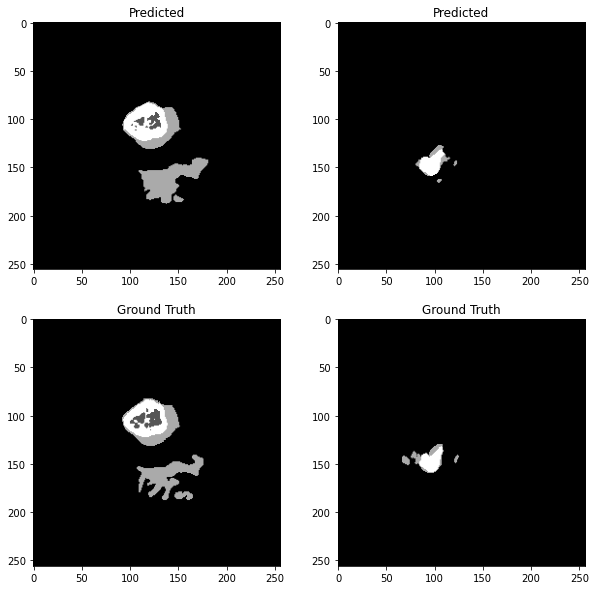

100%|██████████| 993/993 [05:36<00:00,  2.95it/s]


Average Validation Loss: 0.009880186574419159

Average Validation DSC: [0.99876089 0.85314199 0.85896269 0.78864436]
Average Validation ASSD: [ 0.20271772 23.25457879 18.20374717 11.60004386]
Epoch 7/50
-------------------------


  0%|          | 0/3971 [00:00<?, ?it/s]

Training Prediction Visualization:


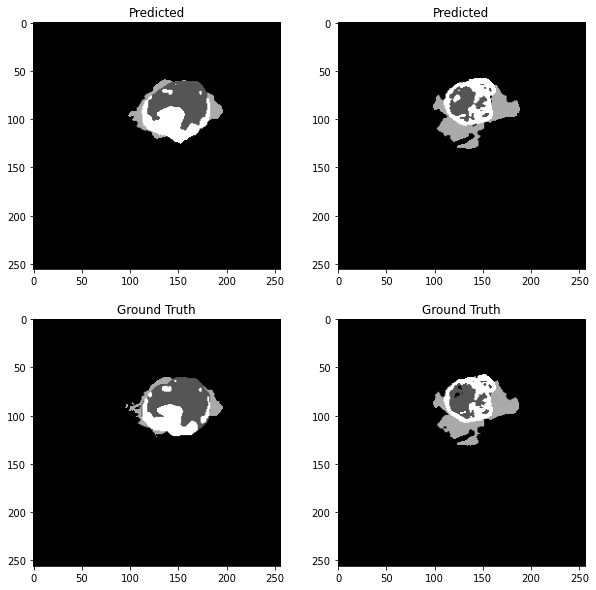

100%|██████████| 3971/3971 [34:06<00:00,  1.94it/s]



Average Training Loss: 0.008489311076627983

Average Training DSC: [0.99889536 0.86062956 0.87327784 0.79449581]
Average Training ASSD: [ 0.1816795  22.0010563  15.09492196 16.43074642]


  0%|          | 0/993 [00:00<?, ?it/s]

Validation Prediction Visualization:


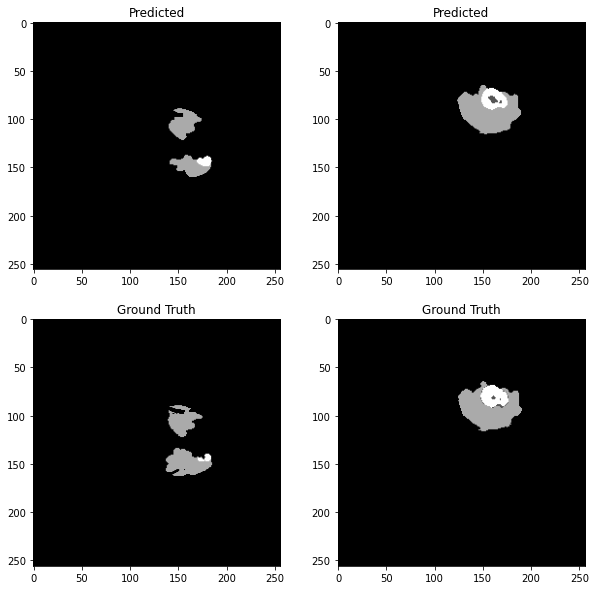

100%|██████████| 993/993 [05:39<00:00,  2.92it/s]


Average Validation Loss: 0.00920005148925705

Average Validation DSC: [0.99884089 0.85447612 0.85754328 0.78564351]
Average Validation ASSD: [ 0.19608989 22.69241925 19.85295937 16.43800872]
Epoch 8/50
-------------------------


  0%|          | 0/3971 [00:00<?, ?it/s]

Training Prediction Visualization:


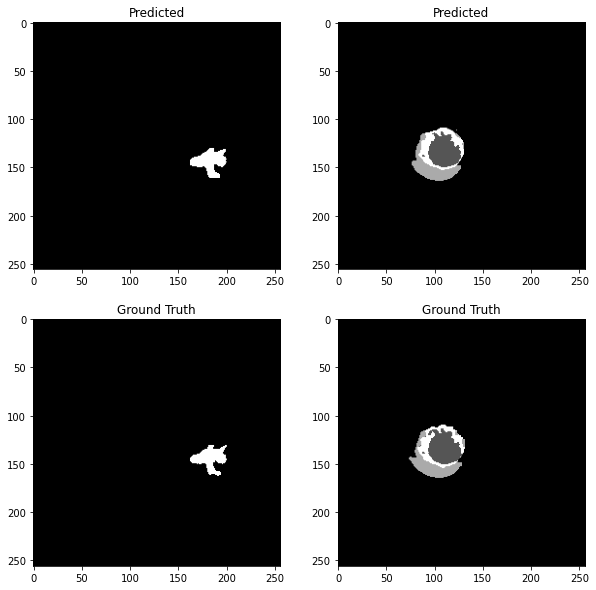

100%|██████████| 3971/3971 [33:07<00:00,  2.00it/s]



Average Training Loss: 0.0077734430373564934

Average Training DSC: [0.99897365 0.8677107  0.88331024 0.80670111]
Average Training ASSD: [ 0.16473067 20.74539828 13.30212377 15.86565118]


  0%|          | 0/993 [00:00<?, ?it/s]

Validation Prediction Visualization:


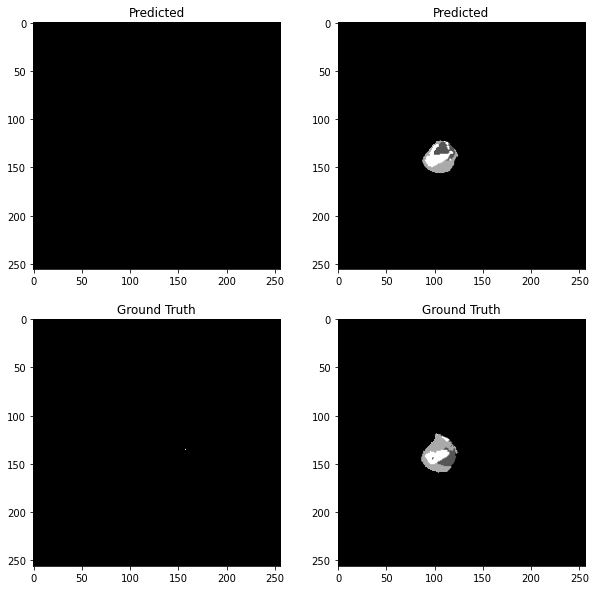

100%|██████████| 993/993 [05:31<00:00,  3.00it/s]


Average Validation Loss: 0.008998407952277382

Average Validation DSC: [0.99888971 0.8591485  0.87505026 0.78279839]
Average Validation ASSD: [ 0.19976785 21.80947967 14.98542891 20.31683082]
Epoch 9/50
-------------------------


  0%|          | 0/3971 [00:00<?, ?it/s]

Training Prediction Visualization:


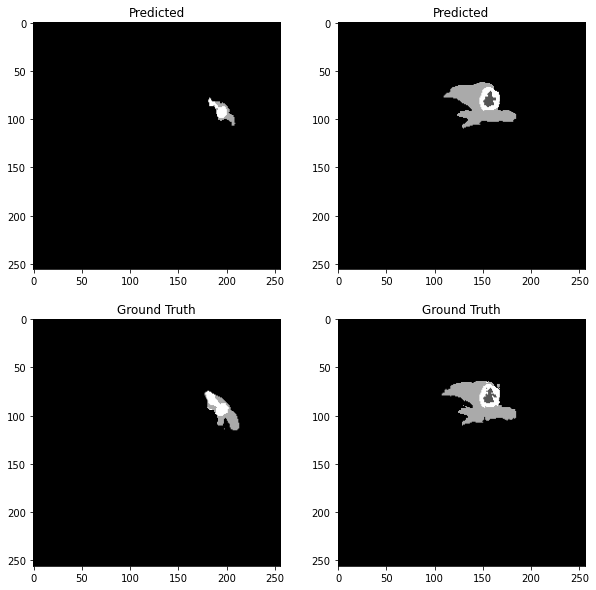

100%|██████████| 3971/3971 [33:49<00:00,  1.96it/s]



Average Training Loss: 0.007232504541915566

Average Training DSC: [0.99903072 0.87445523 0.89243016 0.81671548]
Average Training ASSD: [ 0.15002438 19.10071623 11.46670567 15.09627854]


  0%|          | 0/993 [00:00<?, ?it/s]

Validation Prediction Visualization:


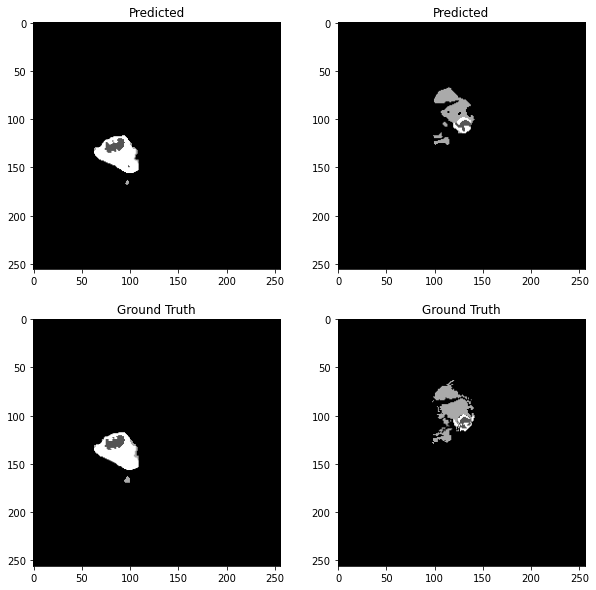

100%|██████████| 993/993 [05:37<00:00,  2.95it/s]


Average Validation Loss: 0.008372938951190415

Average Validation DSC: [0.99894767 0.86427567 0.87344913 0.8076292 ]
Average Validation ASSD: [ 0.16330118 21.11652277 16.6102268  12.80881249]
Epoch 10/50
-------------------------


  0%|          | 0/3971 [00:00<?, ?it/s]

Training Prediction Visualization:


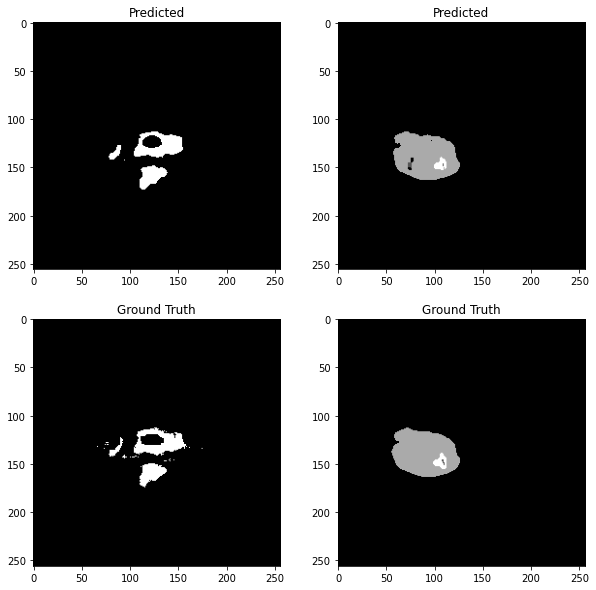

100%|██████████| 3971/3971 [33:50<00:00,  1.96it/s]



Average Training Loss: 0.006735755631958612

Average Training DSC: [0.99908954 0.87995234 0.90012536 0.82518261]
Average Training ASSD: [ 0.13731056 18.17116568 10.22117888 14.65941718]


  0%|          | 0/993 [00:00<?, ?it/s]

Validation Prediction Visualization:


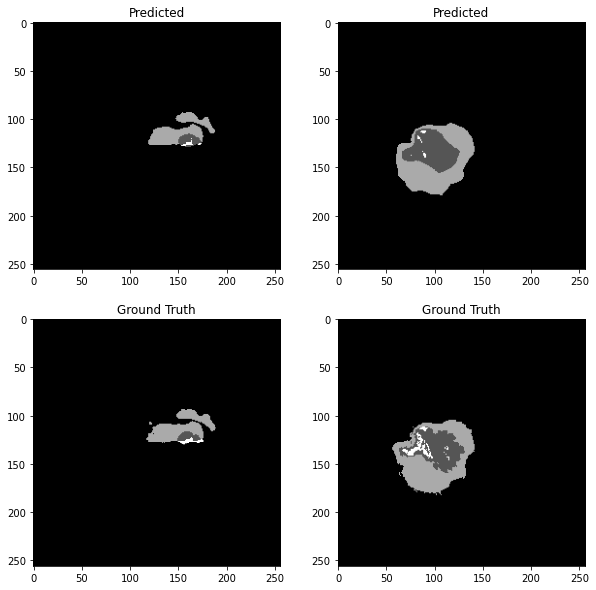

100%|██████████| 993/993 [05:41<00:00,  2.91it/s]


Average Validation Loss: 0.008496278270887734

Average Validation DSC: [0.99892827 0.86200578 0.8687195  0.78909731]
Average Validation ASSD: [ 0.18817375 21.15614534 17.15958807 21.35867532]
Epoch 11/50
-------------------------


  0%|          | 0/3971 [00:00<?, ?it/s]

Training Prediction Visualization:


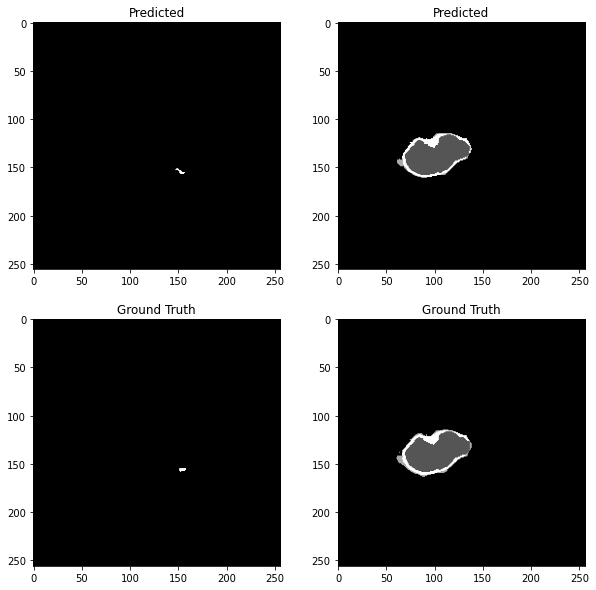

100%|██████████| 3971/3971 [34:19<00:00,  1.93it/s]



Average Training Loss: 0.006430063135248851

Average Training DSC: [0.9991268  0.88392025 0.90549754 0.8310118 ]
Average Training ASSD: [ 0.12957546 17.43281401  9.2120209  14.41615115]


  0%|          | 0/993 [00:00<?, ?it/s]

Validation Prediction Visualization:


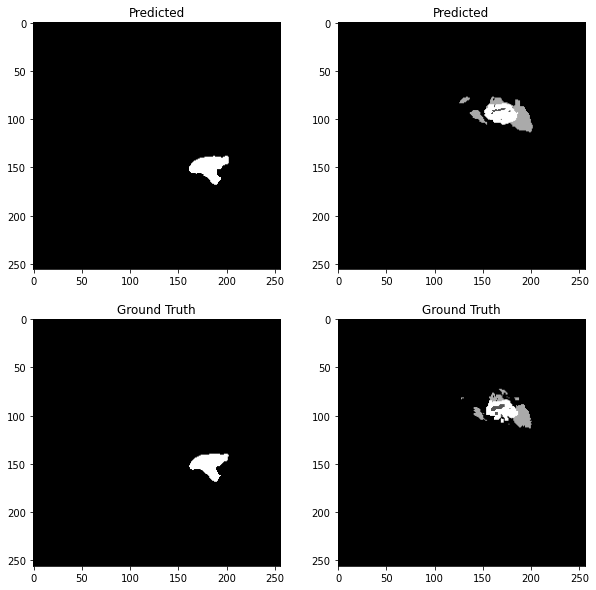

100%|██████████| 993/993 [05:41<00:00,  2.90it/s]


Average Validation Loss: 0.007787778714487905

Average Validation DSC: [0.99904614 0.87692158 0.88184837 0.81103964]
Average Validation ASSD: [ 0.15407183 18.16191514 15.85941882 17.1103336 ]
Epoch 12/50
-------------------------


  0%|          | 0/3971 [00:00<?, ?it/s]

Training Prediction Visualization:


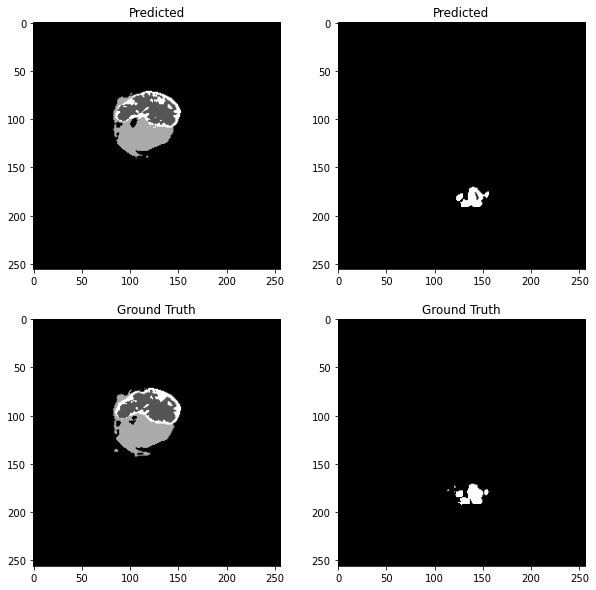

100%|██████████| 3971/3971 [33:42<00:00,  1.96it/s]



Average Training Loss: 0.006033765823031287

Average Training DSC: [0.99916955 0.88860634 0.91122339 0.8387753 ]
Average Training ASSD: [ 0.12089778 16.44848689  8.2374888  13.47706582]


  0%|          | 0/993 [00:00<?, ?it/s]

Validation Prediction Visualization:


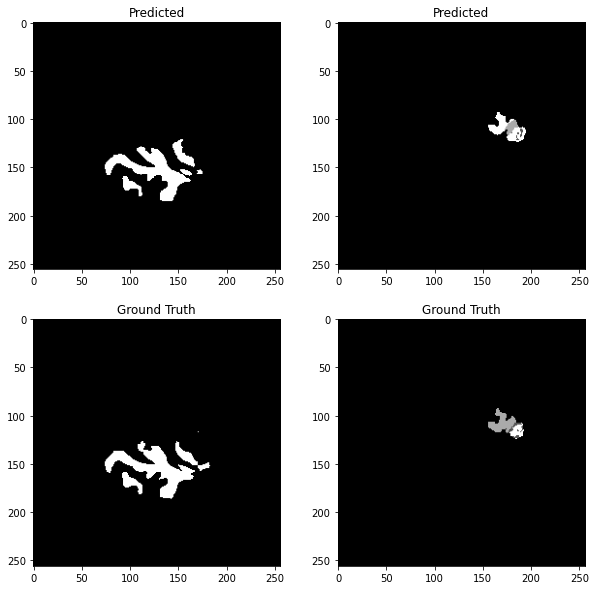

100%|██████████| 993/993 [05:35<00:00,  2.96it/s]


Average Validation Loss: 0.007845492045932486

Average Validation DSC: [0.99907951 0.87939113 0.89304976 0.82468768]
Average Validation ASSD: [ 0.13517374 18.34110316 13.09690272 10.9385876 ]
Epoch 13/50
-------------------------


  0%|          | 0/3971 [00:00<?, ?it/s]

Training Prediction Visualization:


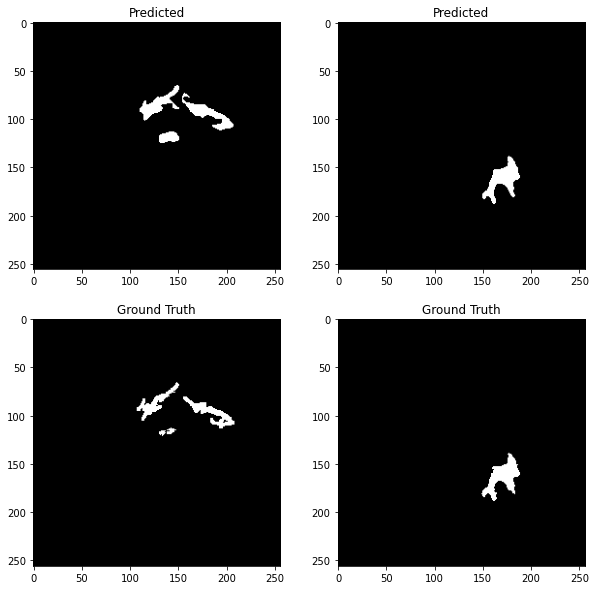

100%|██████████| 3971/3971 [33:54<00:00,  1.95it/s]



Average Training Loss: 0.005813168485908556

Average Training DSC: [0.99919519 0.89195615 0.91484523 0.8438352 ]
Average Training ASSD: [ 0.1165704  15.77350545  7.74277119 13.19451907]


  0%|          | 0/993 [00:00<?, ?it/s]

Validation Prediction Visualization:


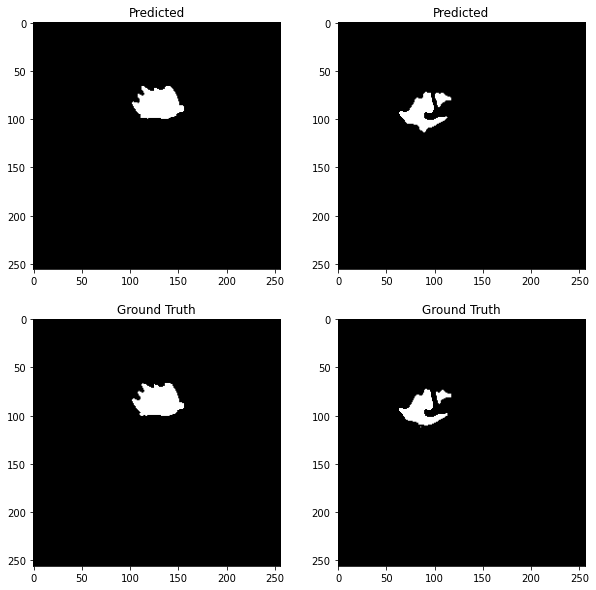

100%|██████████| 993/993 [05:39<00:00,  2.93it/s]


Average Validation Loss: 0.007762583651676519

Average Validation DSC: [0.99908021 0.87909086 0.8921811  0.82119413]
Average Validation ASSD: [ 0.14334368 17.40606311 13.36116491 11.90303545]
Epoch 14/50
-------------------------


  0%|          | 0/3971 [00:00<?, ?it/s]

Training Prediction Visualization:


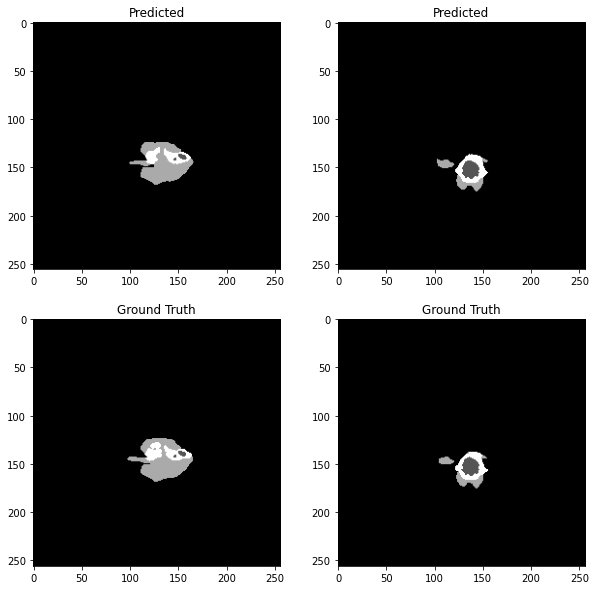

100%|██████████| 3971/3971 [33:55<00:00,  1.95it/s]



Average Training Loss: 0.00551012060025698

Average Training DSC: [0.99923219 0.89566893 0.91913952 0.85049156]
Average Training ASSD: [ 0.10814008 14.94409157  7.05285753 12.59841789]


  0%|          | 0/993 [00:00<?, ?it/s]

Validation Prediction Visualization:


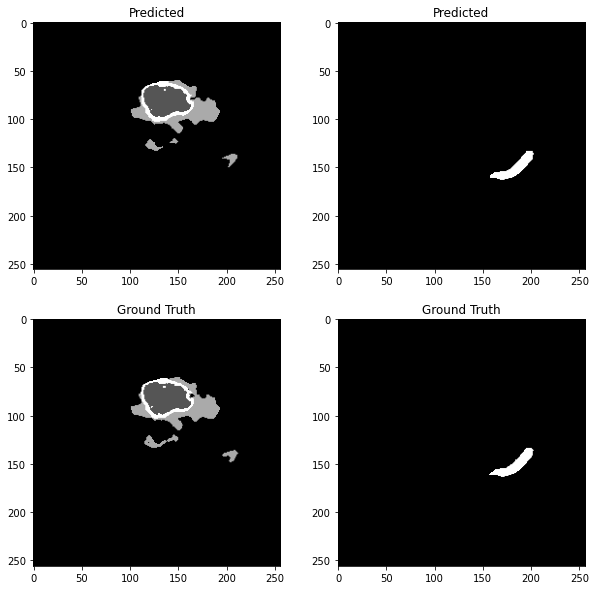

100%|██████████| 993/993 [05:36<00:00,  2.95it/s]


Average Validation Loss: 0.007305754489318842

Average Validation DSC: [0.99911478 0.88501057 0.8932506  0.8285713 ]
Average Validation ASSD: [ 0.13211903 17.16266237 14.0280635  12.82572888]
Epoch 15/50
-------------------------


  0%|          | 0/3971 [00:00<?, ?it/s]

Training Prediction Visualization:


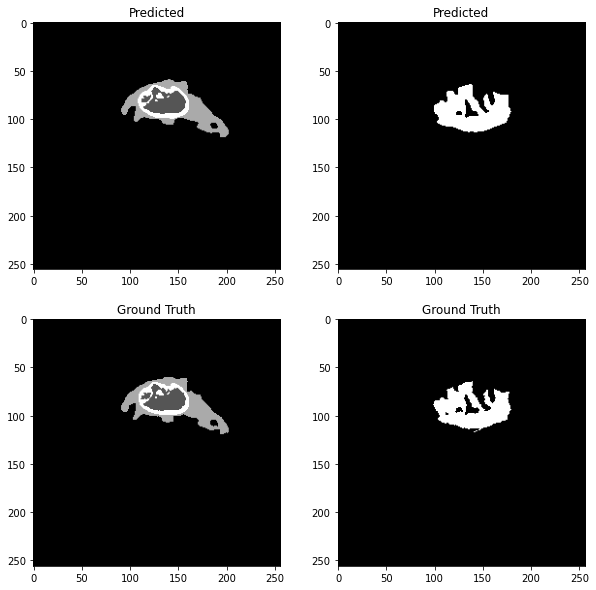

100%|██████████| 3971/3971 [34:24<00:00,  1.92it/s]



Average Training Loss: 0.0053254362163247665

Average Training DSC: [0.99925415 0.89887272 0.92191894 0.85401509]
Average Training ASSD: [ 0.10351959 14.22043209  6.72354787 12.24112652]


  0%|          | 0/993 [00:00<?, ?it/s]

Validation Prediction Visualization:


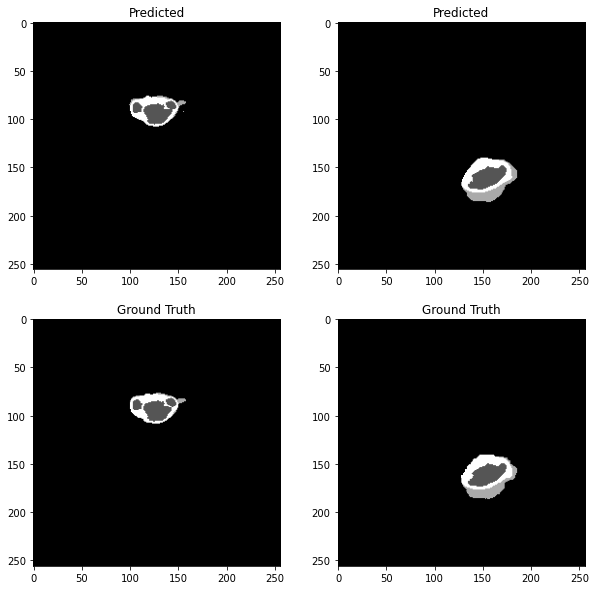

100%|██████████| 993/993 [05:38<00:00,  2.93it/s]


Average Validation Loss: 0.00725973385277374

Average Validation DSC: [0.99916623 0.89095068 0.89285098 0.82890738]
Average Validation ASSD: [ 0.12005591 16.40224393 14.8994135  13.22235511]
Epoch 16/50
-------------------------


  0%|          | 0/3971 [00:00<?, ?it/s]

Training Prediction Visualization:


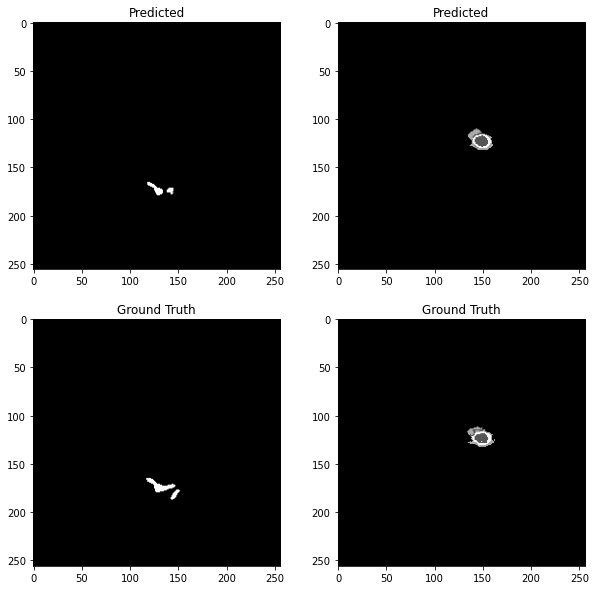

100%|██████████| 3971/3971 [33:25<00:00,  1.98it/s]



Average Training Loss: 0.00514732916357225

Average Training DSC: [0.99928294 0.90103445 0.92616392 0.85947858]
Average Training ASSD: [ 0.09827687 13.98207378  5.99263121 11.78932766]


  0%|          | 0/993 [00:00<?, ?it/s]

Validation Prediction Visualization:


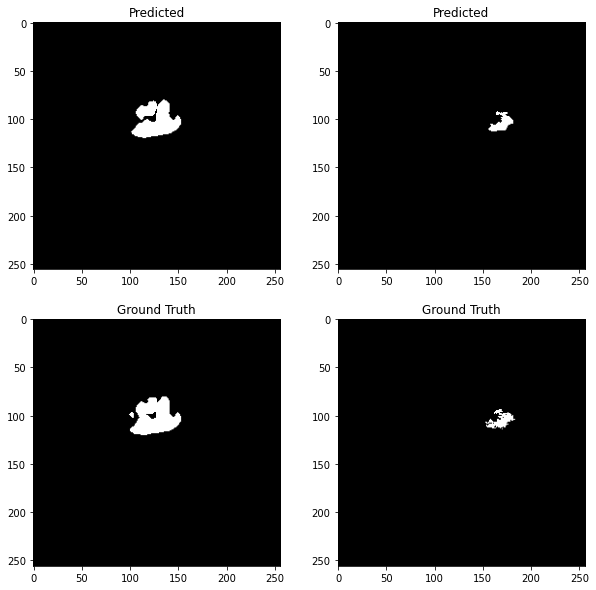

100%|██████████| 993/993 [05:40<00:00,  2.92it/s]


Average Validation Loss: 0.007366158244502988

Average Validation DSC: [0.9991122  0.8891403  0.89586737 0.82515964]
Average Validation ASSD: [ 0.13795357 16.74532405 13.28058853 13.92955764]
Epoch 17/50
-------------------------


  0%|          | 0/3971 [00:00<?, ?it/s]

Training Prediction Visualization:


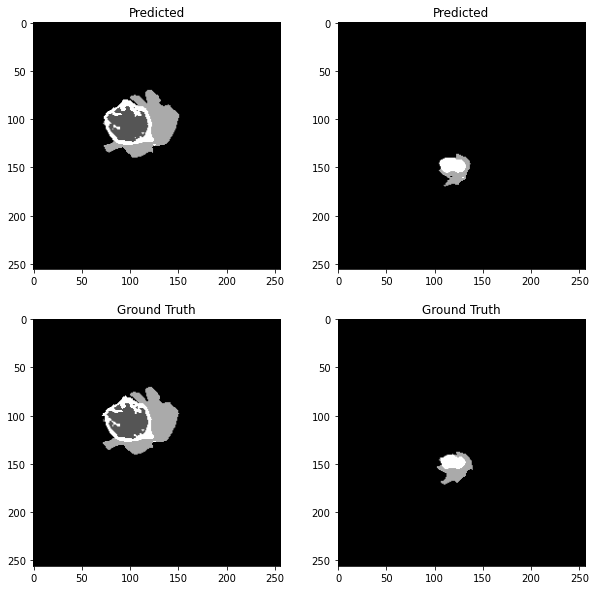

100%|██████████| 3971/3971 [34:17<00:00,  1.93it/s]



Average Training Loss: 0.004937628696871266

Average Training DSC: [0.99930463 0.90438857 0.9289816  0.86330268]
Average Training ASSD: [ 0.09488089 12.97728067  5.58173219 11.36320807]


  0%|          | 0/993 [00:00<?, ?it/s]

Validation Prediction Visualization:


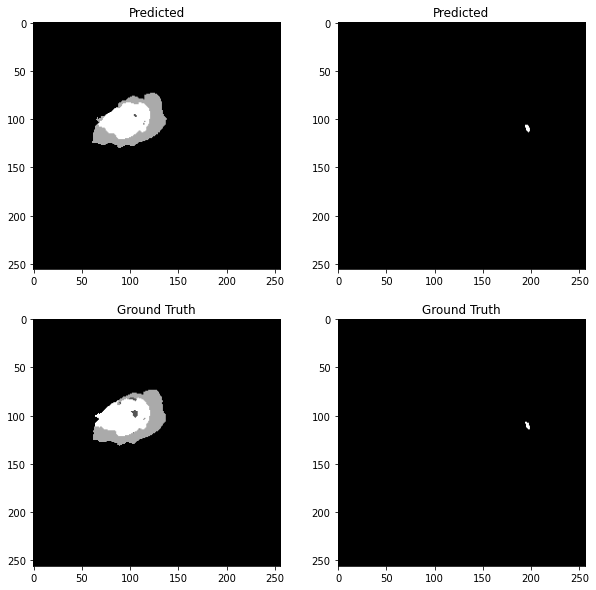

100%|██████████| 993/993 [05:32<00:00,  2.99it/s]


Average Validation Loss: 0.007872685850086769

Average Validation DSC: [0.99912507 0.89008722 0.89739835 0.82678359]
Average Validation ASSD: [ 0.13360014 15.84746575 12.63474089 13.63163433]
Epoch 18/50
-------------------------


  0%|          | 0/3971 [00:00<?, ?it/s]

Training Prediction Visualization:


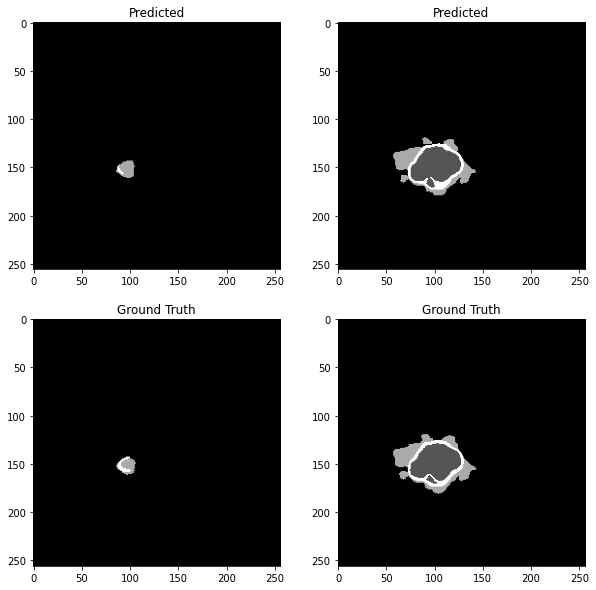

100%|██████████| 3971/3971 [33:12<00:00,  1.99it/s]



Average Training Loss: 0.004851594930470132

Average Training DSC: [0.9993219  0.90555951 0.92998716 0.86584949]
Average Training ASSD: [ 0.09165214 12.95027116  5.65865266 11.23188647]


  0%|          | 0/993 [00:00<?, ?it/s]

Validation Prediction Visualization:


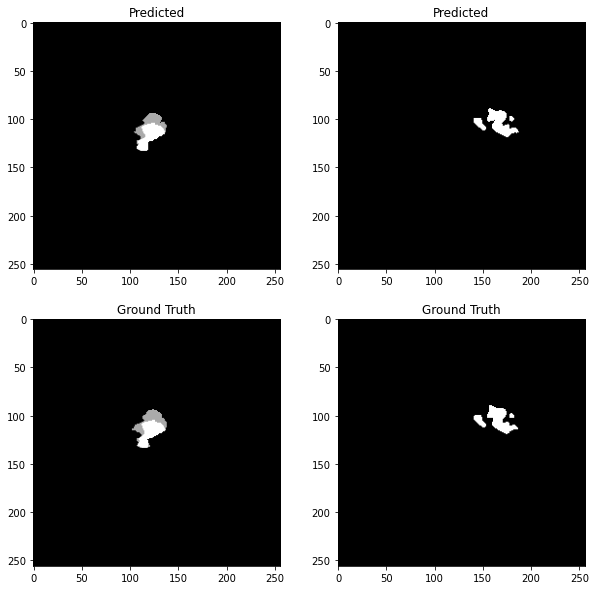

100%|██████████| 993/993 [05:39<00:00,  2.92it/s]


Average Validation Loss: 0.007022547509571892

Average Validation DSC: [0.99915795 0.89057928 0.89365263 0.83812707]
Average Validation ASSD: [ 0.11916577 15.89095041 13.81097481  9.38327986]
Epoch 19/50
-------------------------


  0%|          | 0/3971 [00:00<?, ?it/s]

Training Prediction Visualization:


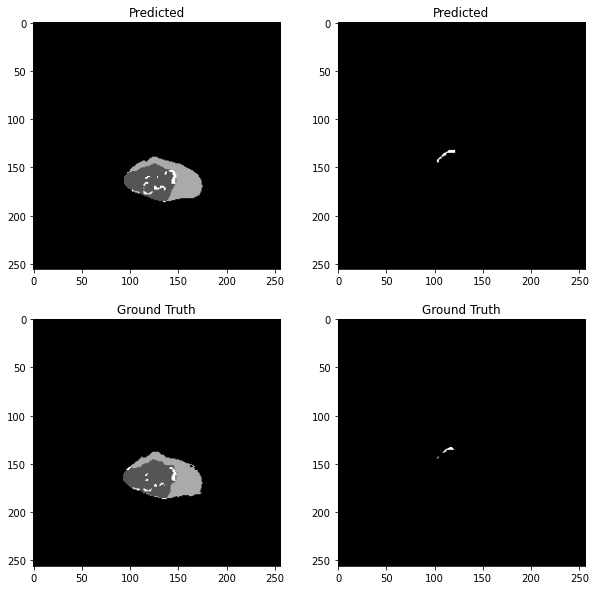

100%|██████████| 3971/3971 [34:13<00:00,  1.93it/s]



Average Training Loss: 0.004576675611384189

Average Training DSC: [0.99934893 0.90919929 0.9343062  0.87131081]
Average Training ASSD: [ 0.08708928 12.07211875  4.80054336 11.07027745]


  0%|          | 0/993 [00:00<?, ?it/s]

Validation Prediction Visualization:


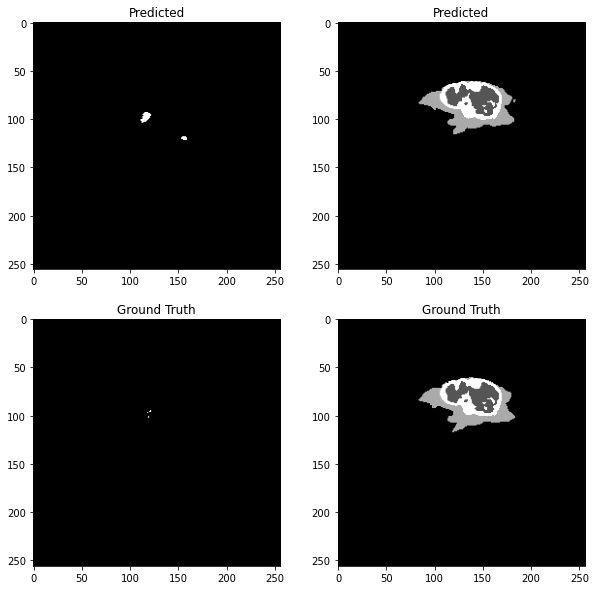

100%|██████████| 993/993 [05:42<00:00,  2.90it/s]


Average Validation Loss: 0.00685405836572865

Average Validation DSC: [0.99919896 0.89163246 0.89412668 0.83848163]
Average Validation ASSD: [ 0.11482936 15.86366121 15.51330989 10.36627635]
Epoch 20/50
-------------------------


  0%|          | 0/3971 [00:00<?, ?it/s]

Training Prediction Visualization:


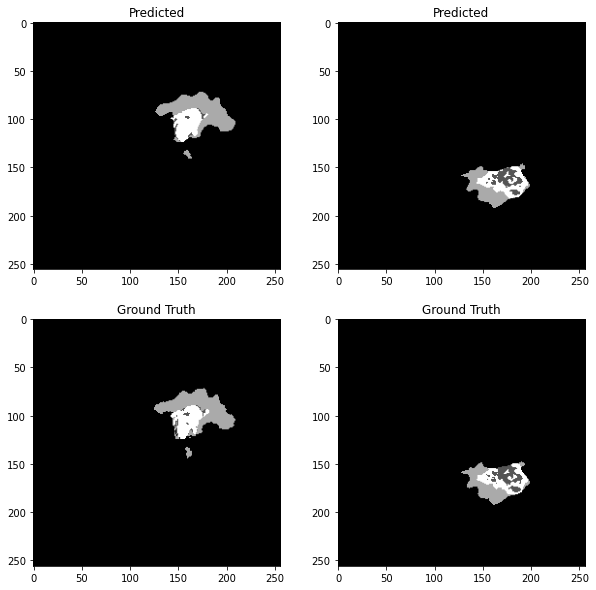

100%|██████████| 3971/3971 [33:55<00:00,  1.95it/s]



Average Training Loss: 0.004432810735188704

Average Training DSC: [0.99936797 0.91130095 0.93549301 0.8744443 ]
Average Training ASSD: [ 0.08406788 11.69220547  5.0069481  10.30342319]


  0%|          | 0/993 [00:00<?, ?it/s]

Validation Prediction Visualization:


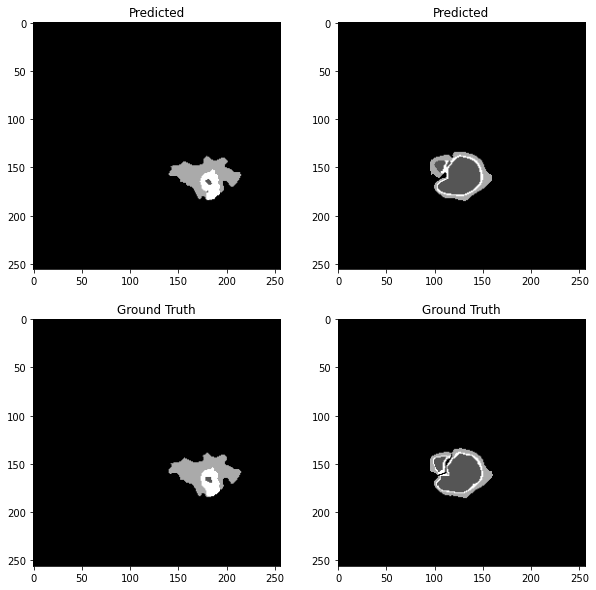

100%|██████████| 993/993 [05:40<00:00,  2.92it/s]


Average Validation Loss: 0.006787224012696206

Average Validation DSC: [0.99923111 0.8959864  0.90175477 0.84349295]
Average Validation ASSD: [ 0.11154487 14.23430407 13.83671944  9.84739652]
Epoch 21/50
-------------------------


  0%|          | 0/3971 [00:00<?, ?it/s]

Training Prediction Visualization:


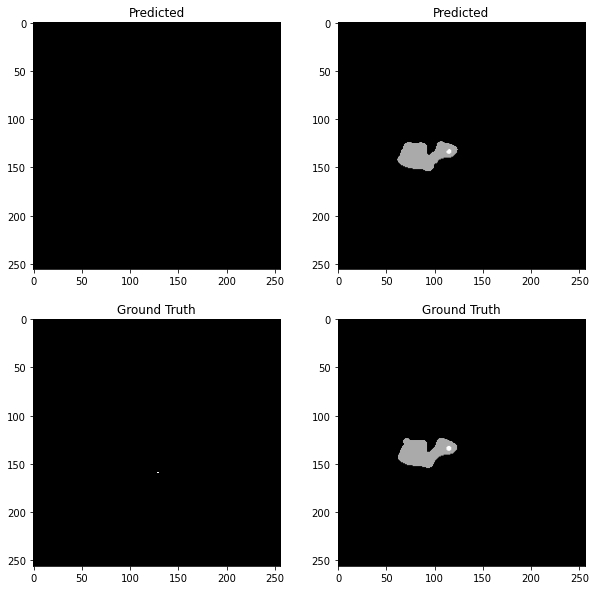

100%|██████████| 3971/3971 [33:28<00:00,  1.98it/s]



Average Training Loss: 0.00431777771945327

Average Training DSC: [0.99938321 0.91333388 0.938511   0.87765981]
Average Training ASSD: [ 0.08084407 11.27648258  4.2821486  10.2756484 ]


  0%|          | 0/993 [00:00<?, ?it/s]

Validation Prediction Visualization:


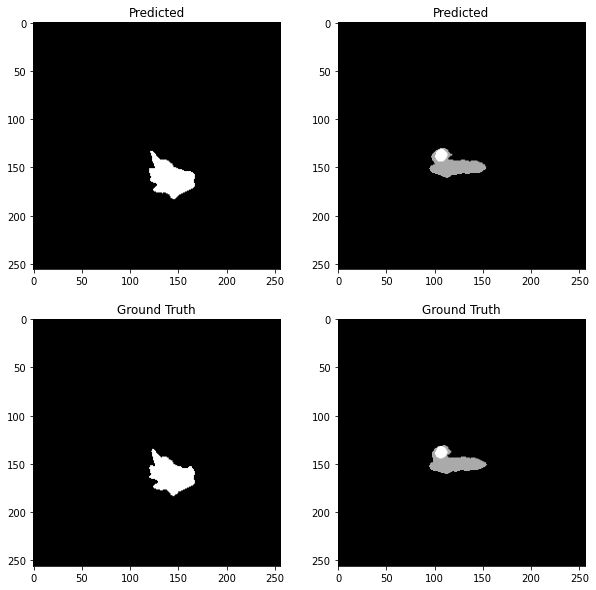

100%|██████████| 993/993 [05:36<00:00,  2.95it/s]


Average Validation Loss: 0.006827393204136963

Average Validation DSC: [0.99923697 0.89565511 0.90764545 0.84583927]
Average Validation ASSD: [ 0.10987151 14.87597157 11.70272573  9.6794669 ]
Epoch 22/50
-------------------------


  0%|          | 0/3971 [00:00<?, ?it/s]

Training Prediction Visualization:


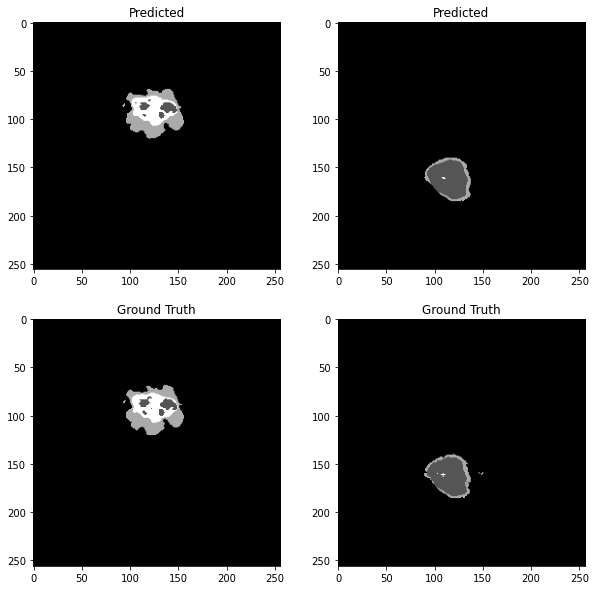

100%|██████████| 3971/3971 [33:33<00:00,  1.97it/s]



Average Training Loss: 0.004162014042096716

Average Training DSC: [0.99940302 0.91541518 0.94092145 0.88117063]
Average Training ASSD: [ 0.07838502 10.62789382  3.89519112  9.88586579]


  0%|          | 0/993 [00:00<?, ?it/s]

Validation Prediction Visualization:


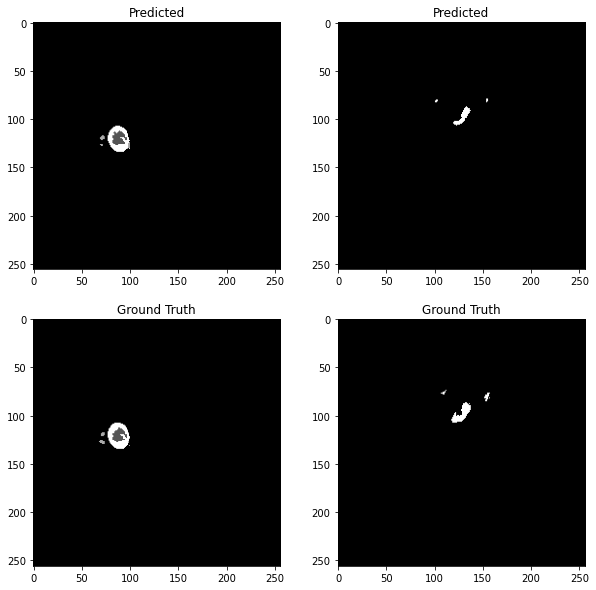

100%|██████████| 993/993 [05:35<00:00,  2.96it/s]


Average Validation Loss: 0.006791313646608834

Average Validation DSC: [0.99923175 0.89854637 0.90372205 0.84461723]
Average Validation ASSD: [ 0.10980378 14.82426023 13.0369433  10.97068405]
Epoch 23/50
-------------------------


  0%|          | 0/3971 [00:00<?, ?it/s]

Training Prediction Visualization:


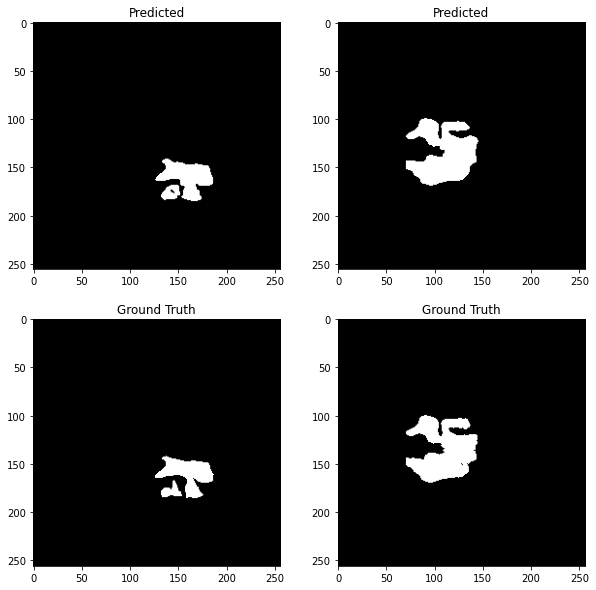

100%|██████████| 3971/3971 [33:29<00:00,  1.98it/s]



Average Training Loss: 0.004064024369110635

Average Training DSC: [0.99941649 0.91739314 0.94230289 0.88361416]
Average Training ASSD: [ 0.07642175 10.33546481  3.77198338  9.77885274]


  0%|          | 0/993 [00:00<?, ?it/s]

Validation Prediction Visualization:


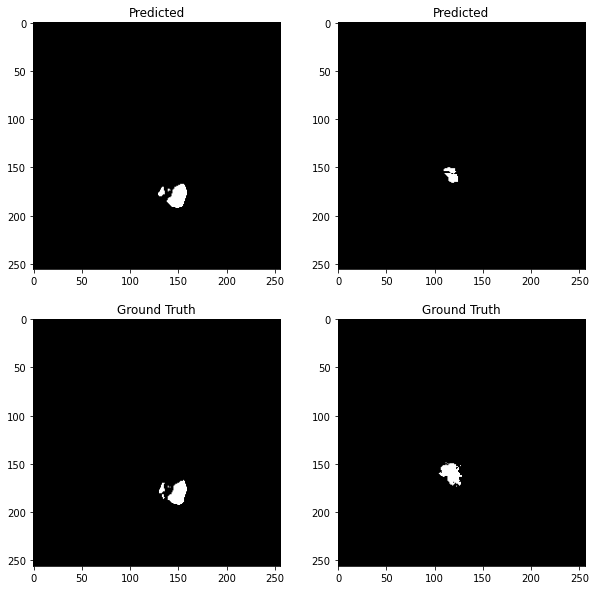

100%|██████████| 993/993 [05:43<00:00,  2.89it/s]


Average Validation Loss: 0.006872286206938529

Average Validation DSC: [0.99927767 0.90300541 0.9118728  0.8519009 ]
Average Validation ASSD: [ 0.10193226 13.10456913 11.58859869  9.09645467]
Epoch 24/50
-------------------------


  0%|          | 0/3971 [00:00<?, ?it/s]

Training Prediction Visualization:


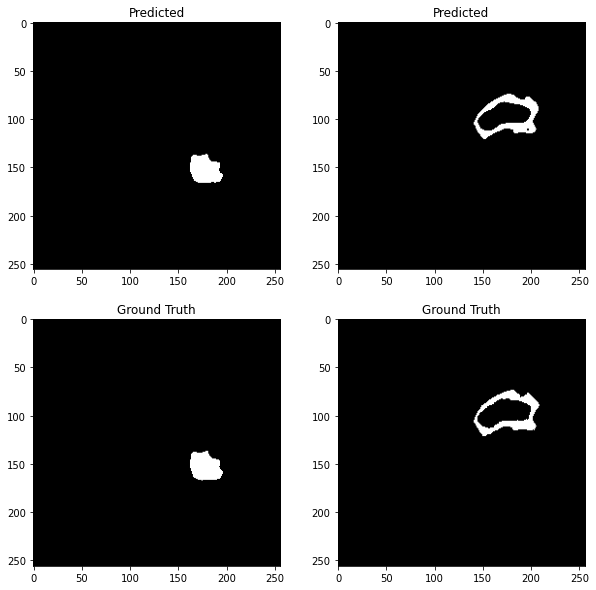

100%|██████████| 3971/3971 [34:03<00:00,  1.94it/s]



Average Training Loss: 0.00397016947401945

Average Training DSC: [0.99943249 0.91875535 0.94326391 0.88601869]
Average Training ASSD: [ 0.07330392 10.07335148  3.78725938  9.53445707]


  0%|          | 0/993 [00:00<?, ?it/s]

Validation Prediction Visualization:


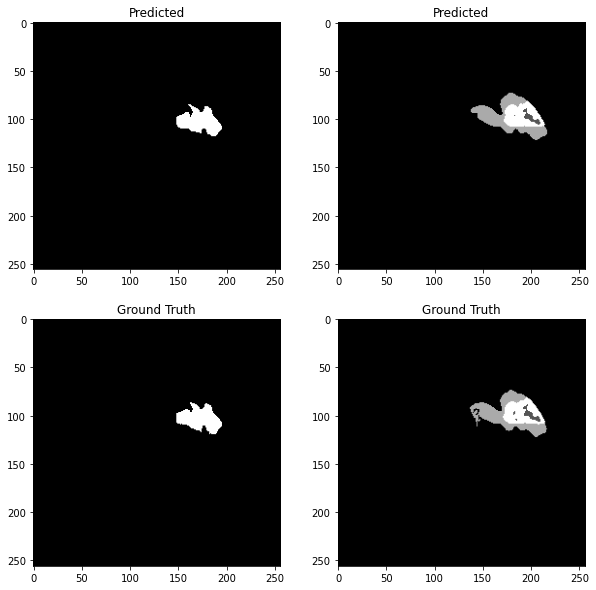

100%|██████████| 993/993 [05:40<00:00,  2.92it/s]


Average Validation Loss: 0.00729560883329339

Average Validation DSC: [0.9992239  0.90028805 0.90634339 0.83888633]
Average Validation ASSD: [ 0.1144629  14.21798515 12.2026118  11.70263294]
Epoch 25/50
-------------------------


  0%|          | 0/3971 [00:00<?, ?it/s]

Training Prediction Visualization:


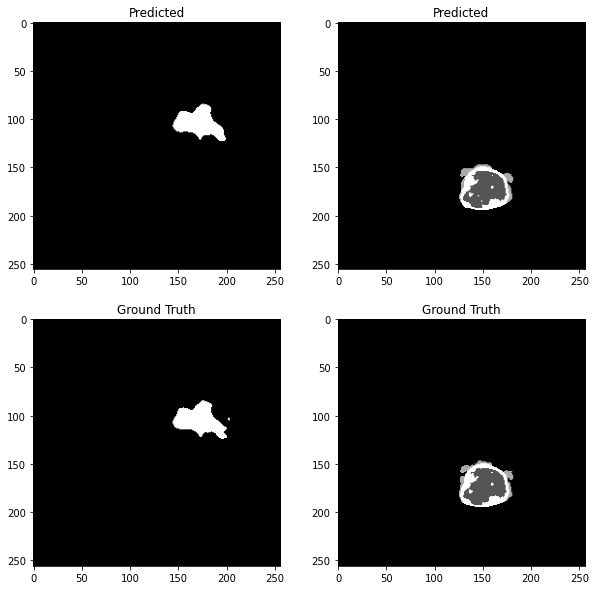

100%|██████████| 3971/3971 [33:52<00:00,  1.95it/s]



Average Training Loss: 0.0038095689325909326

Average Training DSC: [0.99945183 0.92132544 0.9455923  0.89008141]
Average Training ASSD: [0.06978225 9.52262736 3.4163297  8.9481326 ]


  0%|          | 0/993 [00:00<?, ?it/s]

Validation Prediction Visualization:


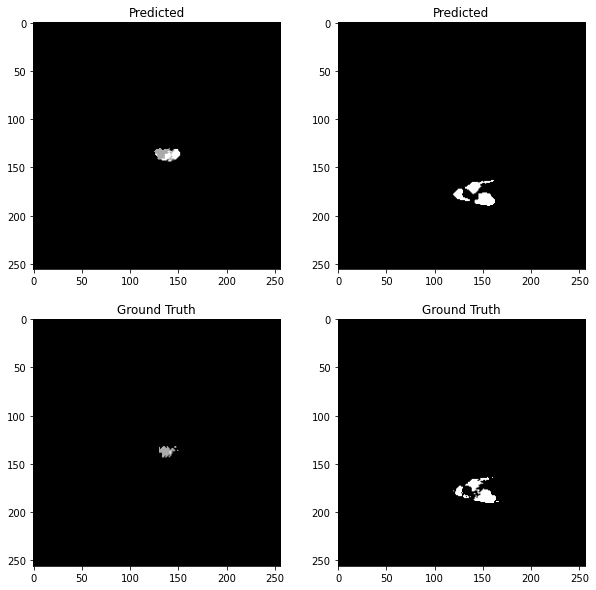

100%|██████████| 993/993 [05:43<00:00,  2.89it/s]


Average Validation Loss: 0.007152848703737961

Average Validation DSC: [0.99921515 0.89660984 0.88955559 0.83911808]
Average Validation ASSD: [ 0.1190896  14.53057314 17.68072328 10.99078858]
Epoch 26/50
-------------------------


  0%|          | 0/3971 [00:00<?, ?it/s]

Training Prediction Visualization:


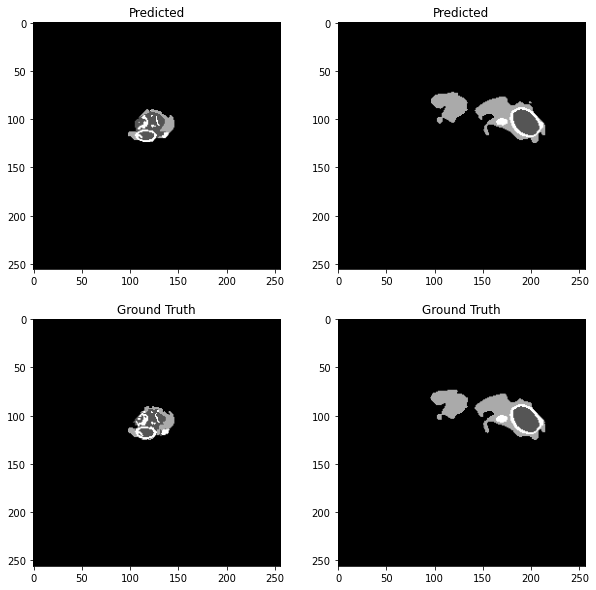

100%|██████████| 3971/3971 [34:21<00:00,  1.93it/s]



Average Training Loss: 0.0037815316000182177

Average Training DSC: [0.99945789 0.92248033 0.94592078 0.89086643]
Average Training ASSD: [0.06917874 9.27079149 3.48447479 8.78621199]


  0%|          | 0/993 [00:00<?, ?it/s]

Validation Prediction Visualization:


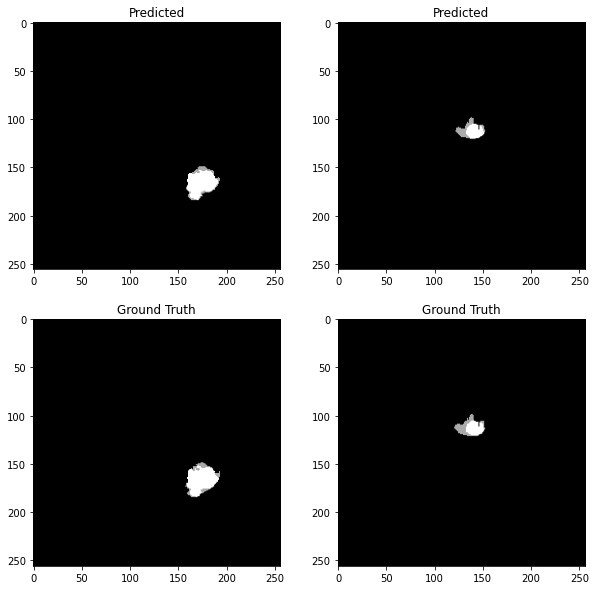

100%|██████████| 993/993 [05:35<00:00,  2.96it/s]


Average Validation Loss: 0.006515953097771947

Average Validation DSC: [0.99928878 0.90367185 0.91003421 0.85146892]
Average Validation ASSD: [ 0.10130481 13.59384484 12.66373977 10.30808569]
Epoch 27/50
-------------------------


  0%|          | 0/3971 [00:00<?, ?it/s]

Training Prediction Visualization:


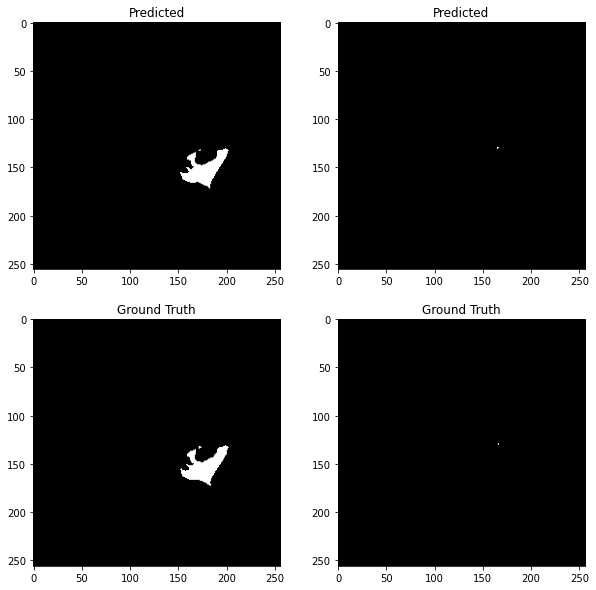

100%|██████████| 3971/3971 [34:04<00:00,  1.94it/s]



Average Training Loss: 0.0036325956280189617

Average Training DSC: [0.99947735 0.92362118 0.9486043  0.8941712 ]
Average Training ASSD: [0.06643241 9.13110448 3.14391975 8.68185561]


  0%|          | 0/993 [00:00<?, ?it/s]

Validation Prediction Visualization:


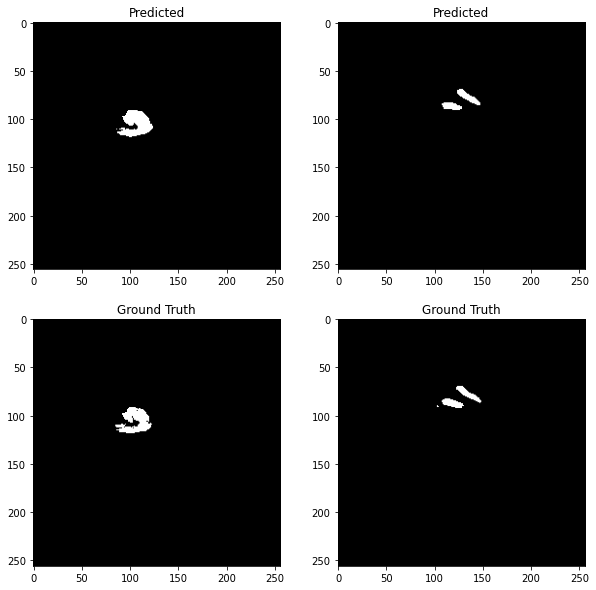

100%|██████████| 993/993 [05:36<00:00,  2.95it/s]


Average Validation Loss: 0.0069002065599369855

Average Validation DSC: [0.99920184 0.89778475 0.87832662 0.83837662]
Average Validation ASSD: [ 0.12028845 14.7533617  20.45746062 10.23342507]
Epoch 28/50
-------------------------


  0%|          | 0/3971 [00:00<?, ?it/s]

Training Prediction Visualization:


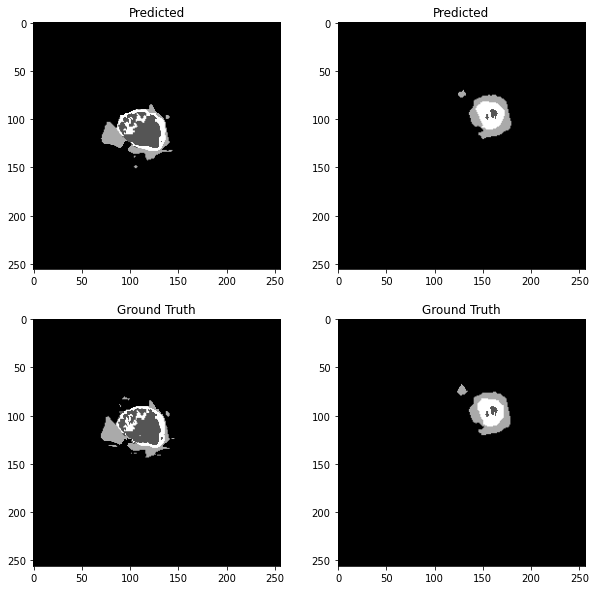

100%|██████████| 3971/3971 [33:22<00:00,  1.98it/s]



Average Training Loss: 0.0036823844348458754

Average Training DSC: [0.99947553 0.92365166 0.94768161 0.89383491]
Average Training ASSD: [0.0667726  9.11129131 3.29618091 8.57432695]


  0%|          | 0/993 [00:00<?, ?it/s]

Validation Prediction Visualization:


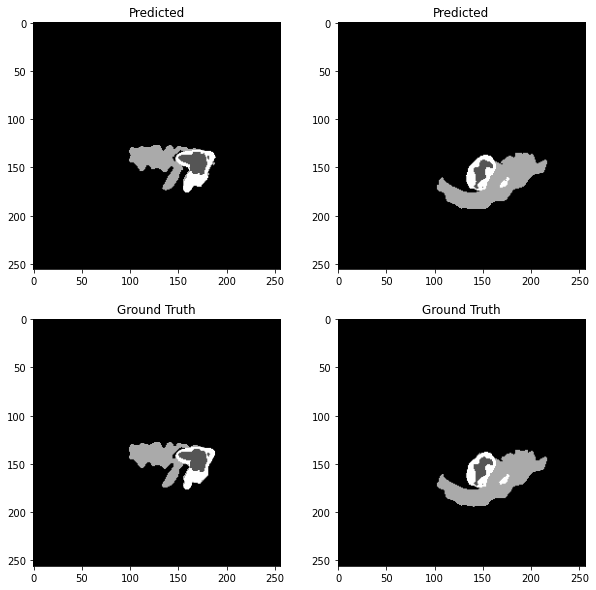

100%|██████████| 993/993 [05:27<00:00,  3.03it/s]


Average Validation Loss: 0.006802424877808849

Average Validation DSC: [0.99930558 0.90634703 0.91183979 0.85310226]
Average Validation ASSD: [ 0.09932494 12.52084787 11.92513634  9.68802741]
Epoch 29/50
-------------------------


  0%|          | 0/3971 [00:00<?, ?it/s]

Training Prediction Visualization:


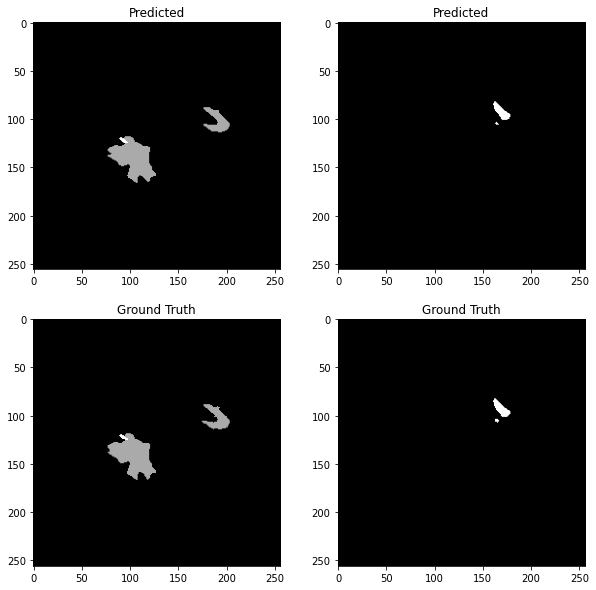

100%|██████████| 3971/3971 [33:23<00:00,  1.98it/s]



Average Training Loss: 0.0034306873353685996

Average Training DSC: [0.99950534 0.92660849 0.95236285 0.89982932]
Average Training ASSD: [0.06147119 8.67256319 2.46352491 8.11803116]


  0%|          | 0/993 [00:00<?, ?it/s]

Validation Prediction Visualization:


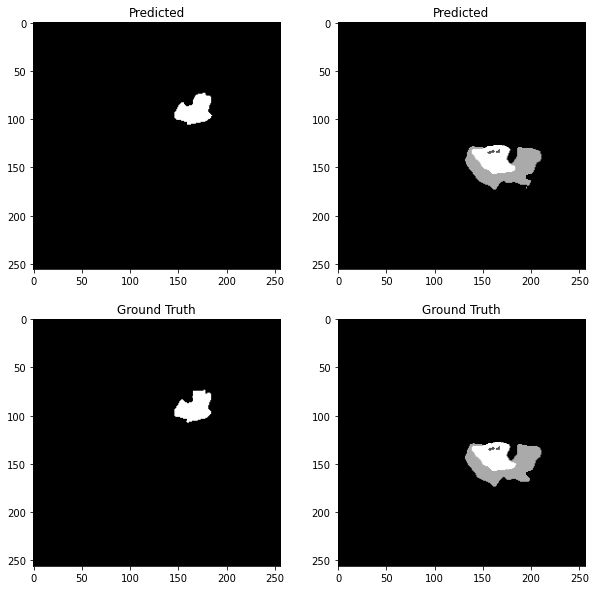

100%|██████████| 993/993 [05:27<00:00,  3.03it/s]


Average Validation Loss: 0.007442242238944451

Average Validation DSC: [0.99929832 0.90338136 0.91340497 0.85586924]
Average Validation ASSD: [ 0.09914523 13.72896089 11.28438207  7.94849378]
Epoch 30/50
-------------------------


  0%|          | 0/3971 [00:00<?, ?it/s]

Training Prediction Visualization:


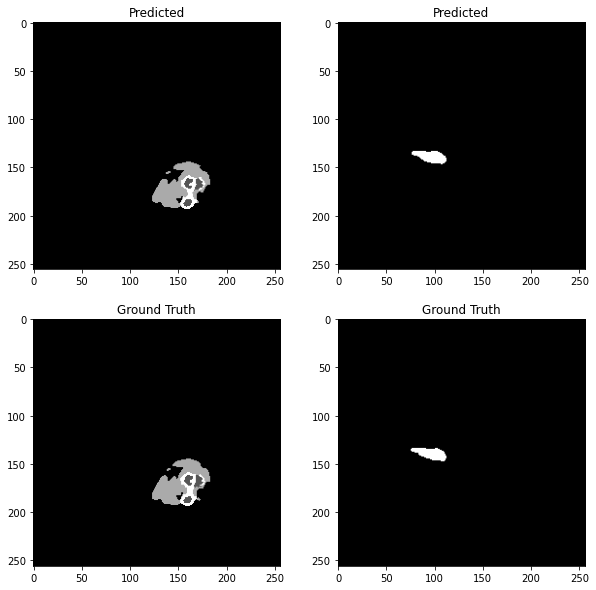

100%|██████████| 3971/3971 [33:21<00:00,  1.98it/s]



Average Training Loss: 0.003375966207101309

Average Training DSC: [0.99951292 0.92753732 0.95282247 0.90108585]
Average Training ASSD: [0.06062216 8.38781744 2.53971553 7.84769461]


  0%|          | 0/993 [00:00<?, ?it/s]

Validation Prediction Visualization:


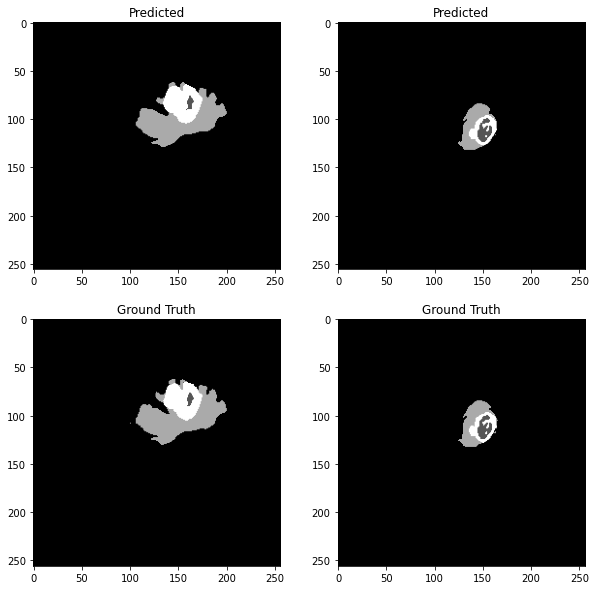

100%|██████████| 993/993 [05:33<00:00,  2.98it/s]


Average Validation Loss: 0.006953808925211175

Average Validation DSC: [0.99930448 0.90738556 0.91222373 0.85452073]
Average Validation ASSD: [ 0.09929486 12.73696933 11.607253   10.01697273]
Epoch 31/50
-------------------------


  0%|          | 0/3971 [00:00<?, ?it/s]

Training Prediction Visualization:


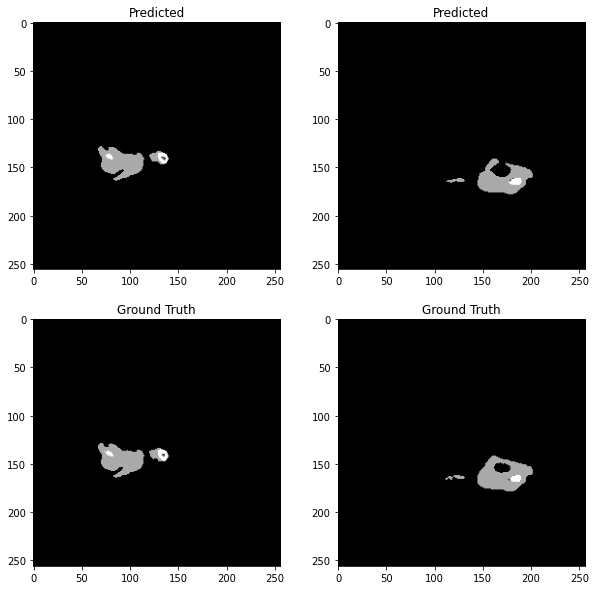

100%|██████████| 3971/3971 [33:34<00:00,  1.97it/s]



Average Training Loss: 0.003386644894483276

Average Training DSC: [0.9995124  0.92816086 0.95217334 0.90060358]
Average Training ASSD: [0.06131526 8.34348377 2.79227598 8.0534842 ]


  0%|          | 0/993 [00:00<?, ?it/s]

Validation Prediction Visualization:


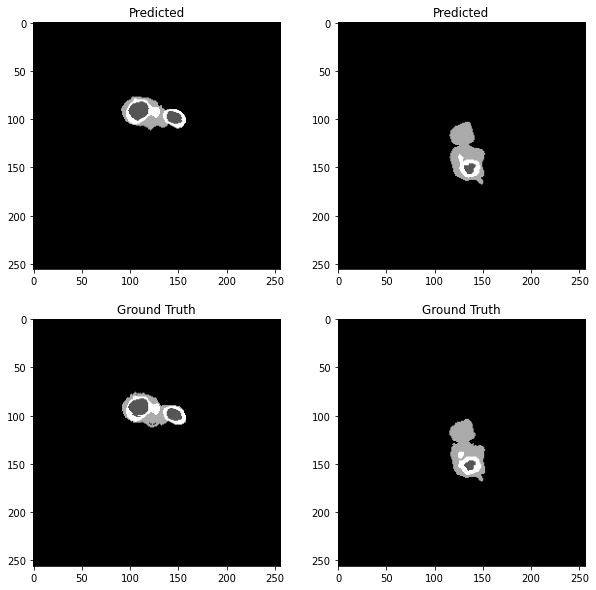

100%|██████████| 993/993 [05:40<00:00,  2.92it/s]


Average Validation Loss: 0.006729697197354947

Average Validation DSC: [0.99931934 0.90779365 0.91250093 0.85843153]
Average Validation ASSD: [ 0.09478814 12.80063902 12.11993381  7.86647173]
Epoch 32/50
-------------------------


  0%|          | 0/3971 [00:00<?, ?it/s]

Training Prediction Visualization:


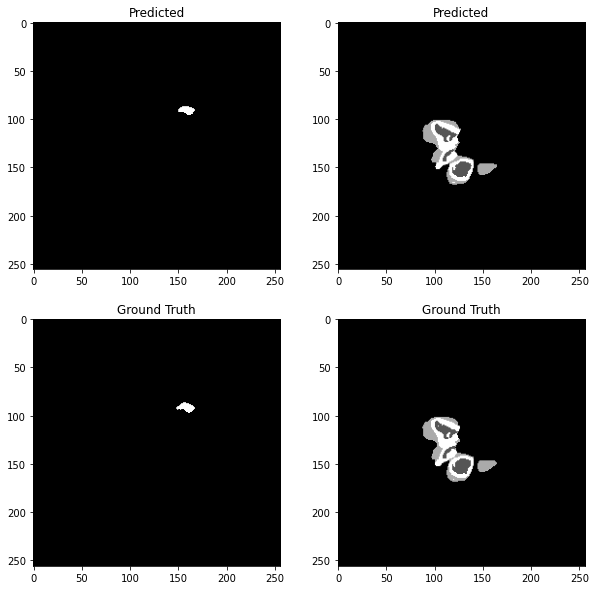

100%|██████████| 3971/3971 [33:17<00:00,  1.99it/s]



Average Training Loss: 0.003206246939205849

Average Training DSC: [0.99953584 0.92951197 0.95494346 0.90460786]
Average Training ASSD: [0.05750957 8.08341533 2.34019034 7.82176645]


  0%|          | 0/993 [00:00<?, ?it/s]

Validation Prediction Visualization:


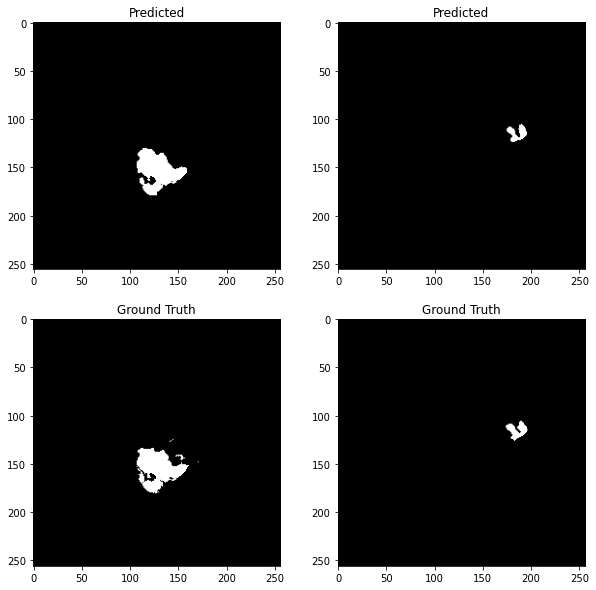

100%|██████████| 993/993 [05:30<00:00,  3.01it/s]


Average Validation Loss: 0.006866603488316394

Average Validation DSC: [0.99926241 0.90184052 0.89723363 0.84582009]
Average Validation ASSD: [ 0.10501701 13.12442389 16.45257694 10.22508488]
Epoch 33/50
-------------------------


  0%|          | 0/3971 [00:00<?, ?it/s]

Training Prediction Visualization:


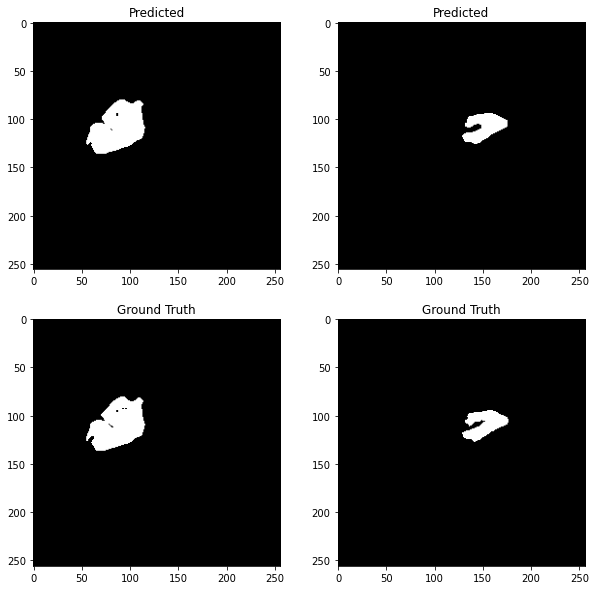

100%|██████████| 3971/3971 [33:18<00:00,  1.99it/s]



Average Training Loss: 0.0031609910482705366

Average Training DSC: [0.99954418 0.93158818 0.95599897 0.90626882]
Average Training ASSD: [0.05616909 7.43955215 2.2028469  7.58400044]


  0%|          | 0/993 [00:00<?, ?it/s]

Validation Prediction Visualization:


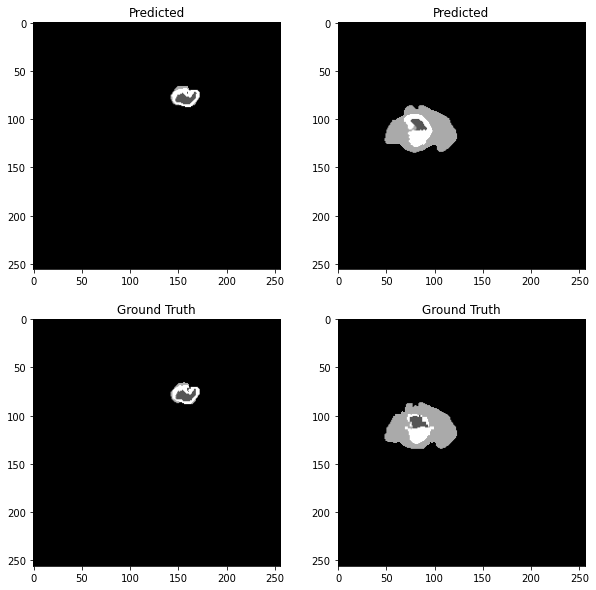

100%|██████████| 993/993 [05:33<00:00,  2.98it/s]


Average Validation Loss: 0.007055641892192602

Average Validation DSC: [0.99932334 0.90761558 0.91541302 0.85969562]
Average Validation ASSD: [ 0.09366467 12.44586852 11.48797678  7.17641336]
Epoch 34/50
-------------------------


  0%|          | 0/3971 [00:00<?, ?it/s]

Training Prediction Visualization:


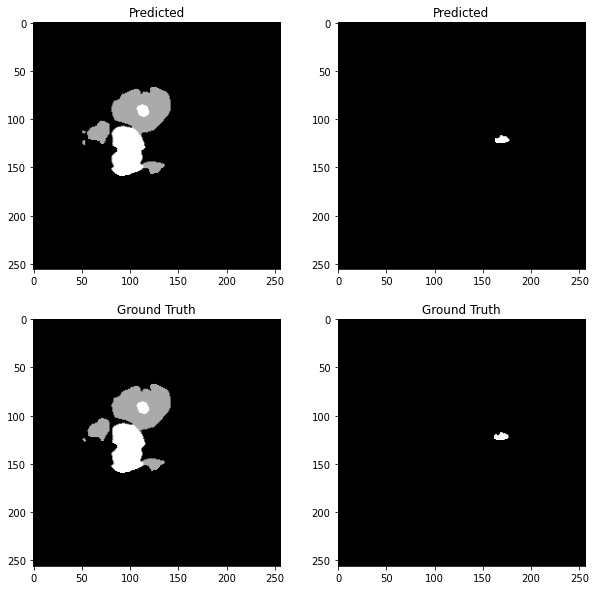

100%|██████████| 3971/3971 [33:34<00:00,  1.97it/s]



Average Training Loss: 0.003113530645620953

Average Training DSC: [0.9995529  0.93238767 0.95640556 0.90726639]
Average Training ASSD: [0.05539325 7.53289664 2.2765016  7.58237871]


  0%|          | 0/993 [00:00<?, ?it/s]

Validation Prediction Visualization:


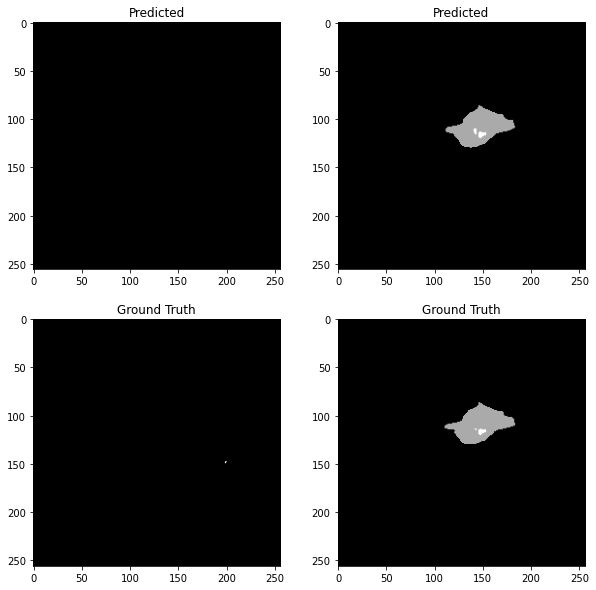

100%|██████████| 993/993 [05:42<00:00,  2.90it/s]


Average Validation Loss: 0.007135060492036386

Average Validation DSC: [0.99932278 0.90433678 0.91459481 0.85841361]
Average Validation ASSD: [ 0.09375811 13.43439679 11.17257359  8.1039426 ]
Epoch 35/50
-------------------------


  0%|          | 0/3971 [00:00<?, ?it/s]

Training Prediction Visualization:


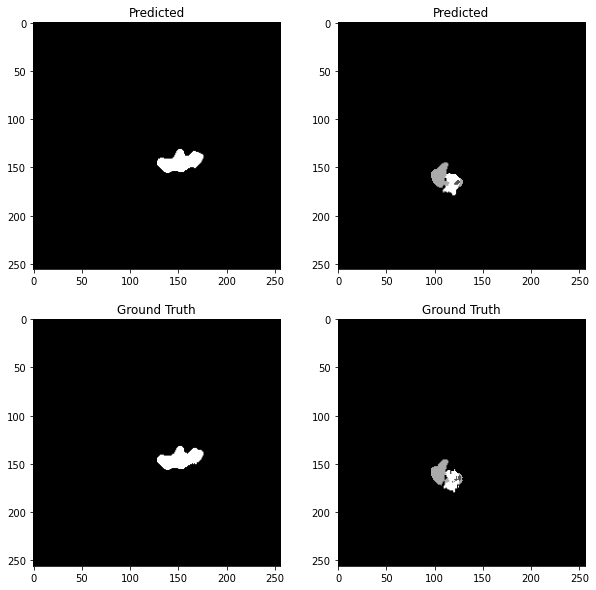

100%|██████████| 3971/3971 [33:35<00:00,  1.97it/s]



Average Training Loss: 0.003076374487609217

Average Training DSC: [0.99955884 0.93251727 0.95669466 0.90912275]
Average Training ASSD: [0.05427236 7.52156936 2.3687516  7.1878652 ]


  0%|          | 0/993 [00:00<?, ?it/s]

Validation Prediction Visualization:


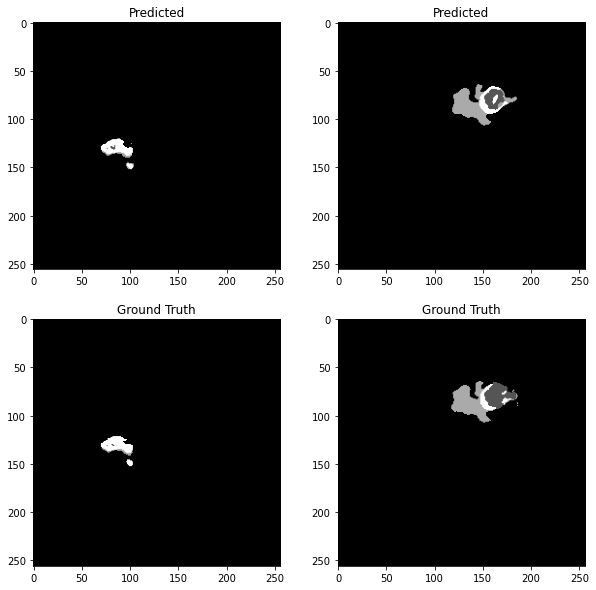

100%|██████████| 993/993 [05:31<00:00,  3.00it/s]


Average Validation Loss: 0.007109807646427255

Average Validation DSC: [0.9992608  0.90375774 0.90860126 0.85261487]
Average Validation ASSD: [ 0.10751642 13.86882034 12.00783969  7.90445392]
Epoch 36/50
-------------------------


  0%|          | 0/3971 [00:00<?, ?it/s]

Training Prediction Visualization:


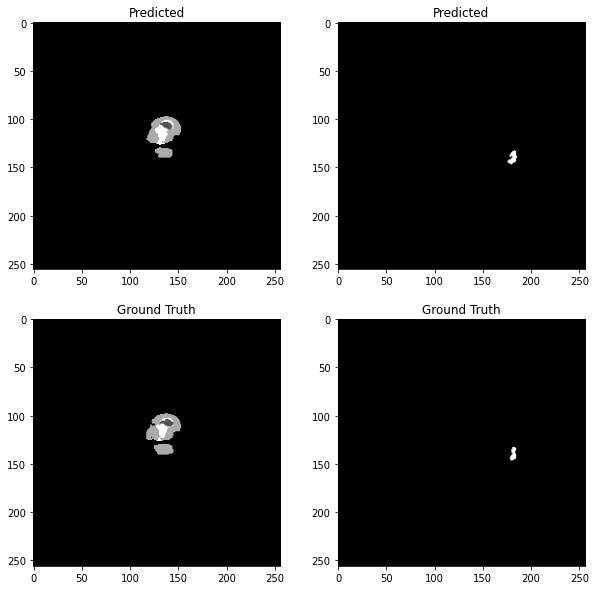

100%|██████████| 3971/3971 [33:19<00:00,  1.99it/s]



Average Training Loss: 0.002987921998060506

Average Training DSC: [0.99956985 0.93369988 0.95820446 0.91047681]
Average Training ASSD: [0.05256011 7.30137859 2.02893737 7.1522568 ]


  0%|          | 0/993 [00:00<?, ?it/s]

Validation Prediction Visualization:


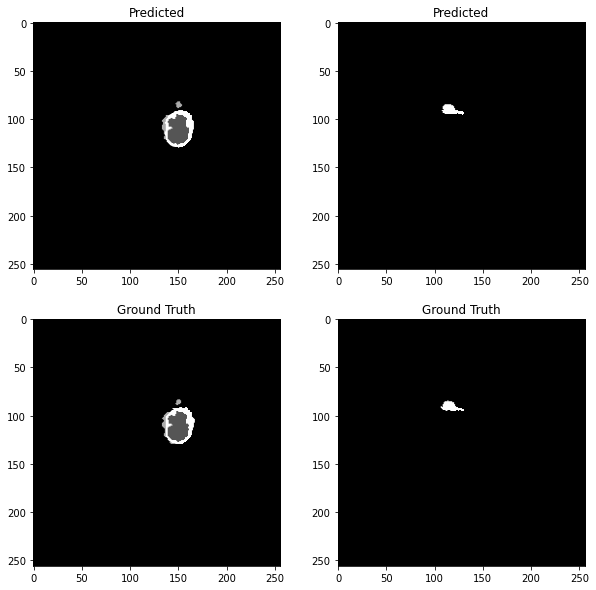

100%|██████████| 993/993 [05:25<00:00,  3.05it/s]


Average Validation Loss: 0.0071287712026931425

Average Validation DSC: [0.99933536 0.90951361 0.91430222 0.85843084]
Average Validation ASSD: [ 0.09231737 12.25196222 11.64362976  8.65227793]
Epoch 37/50
-------------------------


  0%|          | 0/3971 [00:00<?, ?it/s]

Training Prediction Visualization:


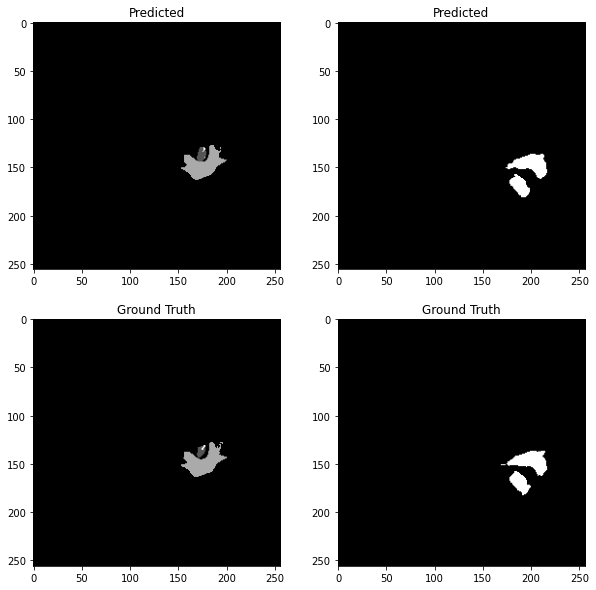

100%|██████████| 3971/3971 [33:20<00:00,  1.99it/s]



Average Training Loss: 0.0029739156104537493

Average Training DSC: [0.99957453 0.93459548 0.95798333 0.91120325]
Average Training ASSD: [0.0521047  7.1467303  2.30538908 6.99028275]


  0%|          | 0/993 [00:00<?, ?it/s]

Validation Prediction Visualization:


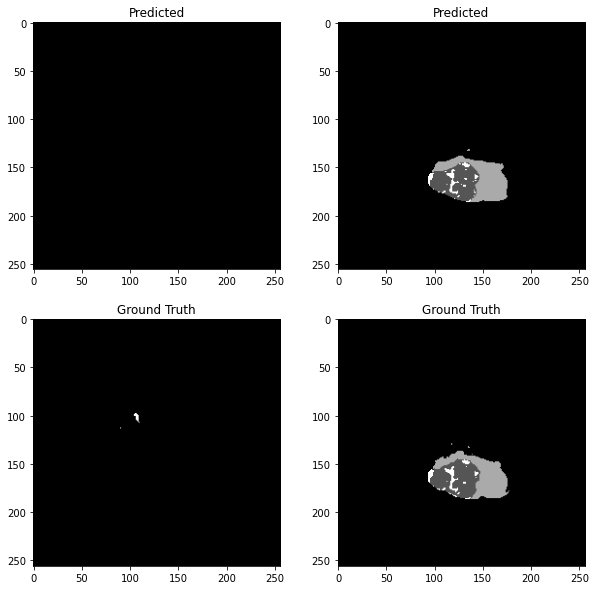

100%|██████████| 993/993 [05:34<00:00,  2.97it/s]


Average Validation Loss: 0.0070215080834715084

Average Validation DSC: [0.99933567 0.90955469 0.9141592  0.85934007]
Average Validation ASSD: [ 0.09230652 12.72389831 11.97276282  7.95659246]
Epoch 38/50
-------------------------


  0%|          | 0/3971 [00:00<?, ?it/s]

Training Prediction Visualization:


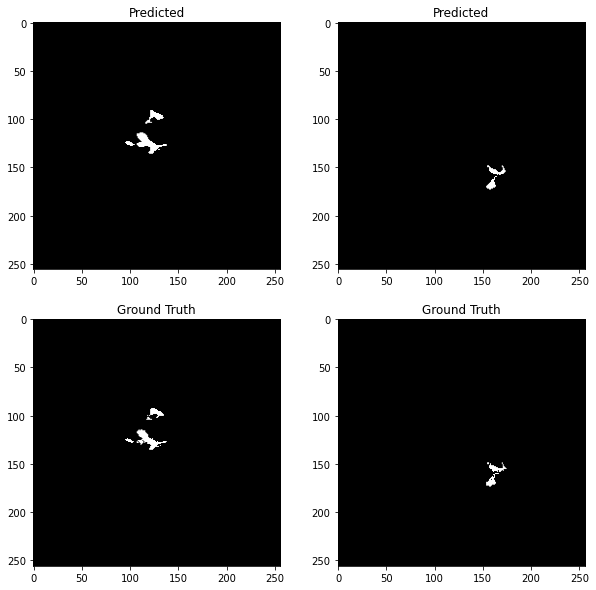

100%|██████████| 3971/3971 [33:36<00:00,  1.97it/s]



Average Training Loss: 0.0028992477731483238

Average Training DSC: [0.99958548 0.93595429 0.95906273 0.91298738]
Average Training ASSD: [0.05066653 6.81393994 2.20800722 7.01357488]


  0%|          | 0/993 [00:00<?, ?it/s]

Validation Prediction Visualization:


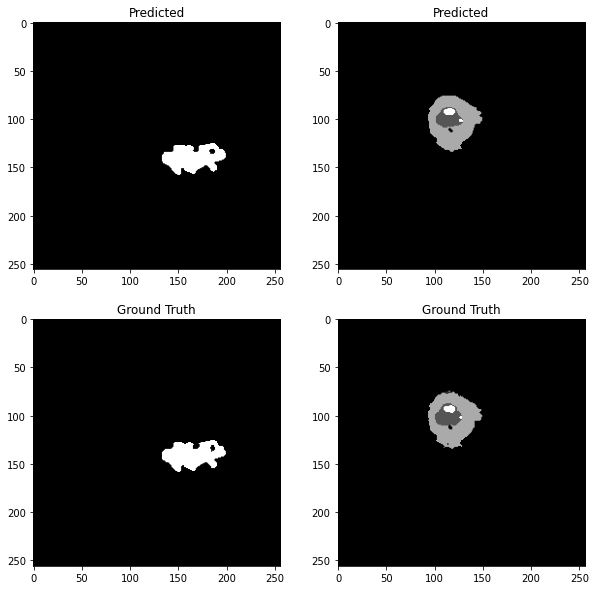

100%|██████████| 993/993 [05:41<00:00,  2.91it/s]


Average Validation Loss: 0.006919067873772372

Average Validation DSC: [0.99933596 0.91152931 0.91564419 0.86203867]
Average Validation ASSD: [ 0.09304663 11.81221094 11.52370478  6.67299188]
Epoch 39/50
-------------------------


  0%|          | 0/3971 [00:00<?, ?it/s]

Training Prediction Visualization:


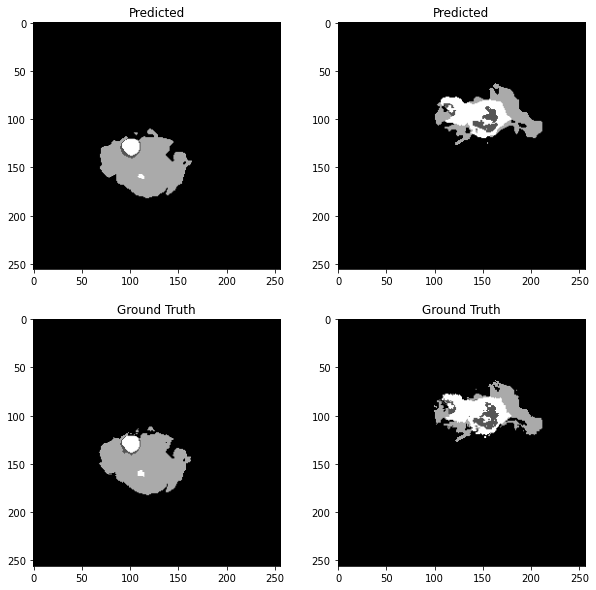

100%|██████████| 3971/3971 [34:36<00:00,  1.91it/s]



Average Training Loss: 0.002826539463341542

Average Training DSC: [0.99959544 0.93649919 0.96035186 0.91527466]
Average Training ASSD: [0.04927453 6.85270564 1.85675131 6.86584097]


  0%|          | 0/993 [00:00<?, ?it/s]

Validation Prediction Visualization:


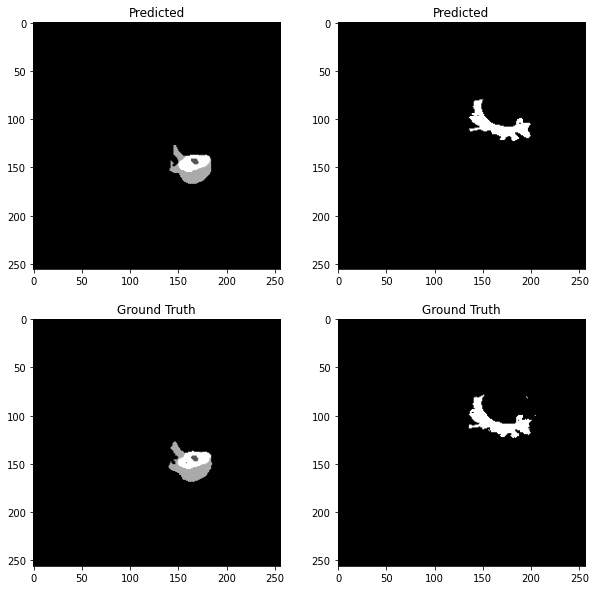

100%|██████████| 993/993 [05:43<00:00,  2.89it/s]


Average Validation Loss: 0.00725986149789501

Average Validation DSC: [0.99934408 0.91143062 0.91624477 0.86203154]
Average Validation ASSD: [ 0.09131763 11.88094747 11.25166985  7.88848366]
Epoch 40/50
-------------------------


  0%|          | 0/3971 [00:00<?, ?it/s]

Training Prediction Visualization:


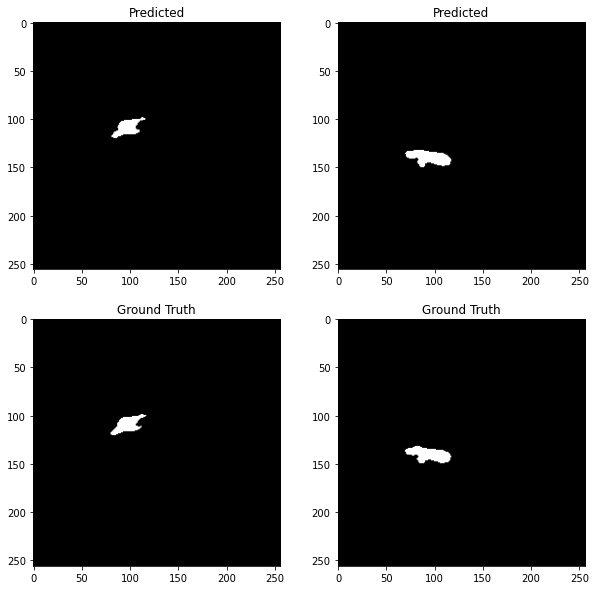

100%|██████████| 3971/3971 [33:30<00:00,  1.98it/s]



Average Training Loss: 0.0028501521390014934

Average Training DSC: [0.99959414 0.93661803 0.95991493 0.91469049]
Average Training ASSD: [0.04930065 6.82842202 2.0396735  6.64172241]


  0%|          | 0/993 [00:00<?, ?it/s]

Validation Prediction Visualization:


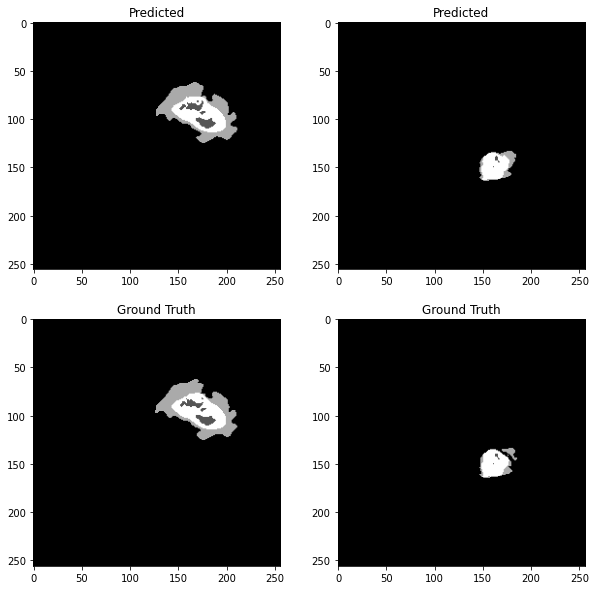

100%|██████████| 993/993 [05:46<00:00,  2.87it/s]


Average Validation Loss: 0.006955103564647299

Average Validation DSC: [0.99933744 0.91007684 0.91573425 0.8620578 ]
Average Validation ASSD: [ 0.09190982 12.05071033 11.29321104  6.84441024]
Epoch 41/50
-------------------------


  0%|          | 0/3971 [00:00<?, ?it/s]

Training Prediction Visualization:


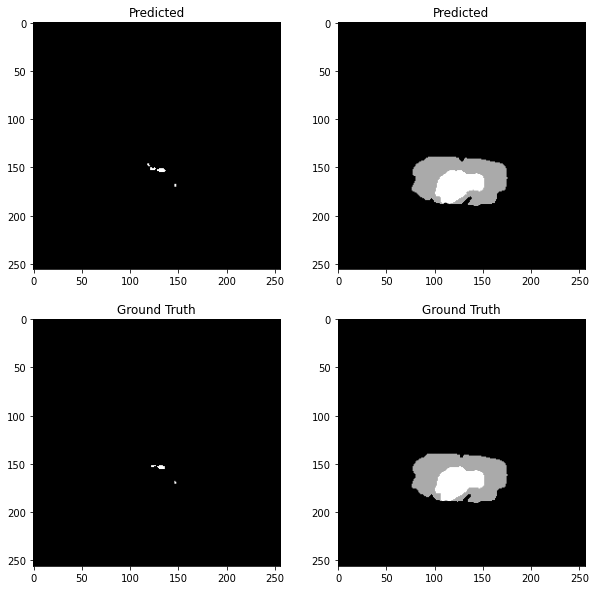

100%|██████████| 3971/3971 [33:54<00:00,  1.95it/s]



Average Training Loss: 0.00277349317073564

Average Training DSC: [0.99960806 0.93693659 0.96093469 0.91690317]
Average Training ASSD: [0.04740516 6.89528677 2.08231615 6.61313205]


  0%|          | 0/993 [00:00<?, ?it/s]

Validation Prediction Visualization:


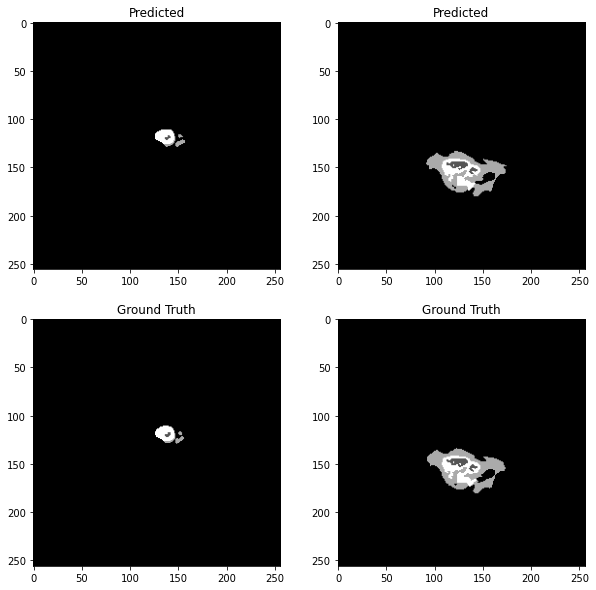

100%|██████████| 993/993 [05:28<00:00,  3.03it/s]


Average Validation Loss: 0.007079098115732363

Average Validation DSC: [0.9992335  0.8990862  0.90711883 0.85133084]
Average Validation ASSD: [ 0.11685115 14.51672937 12.77189015  4.91609838]
Epoch 42/50
-------------------------


  0%|          | 0/3971 [00:00<?, ?it/s]

Training Prediction Visualization:


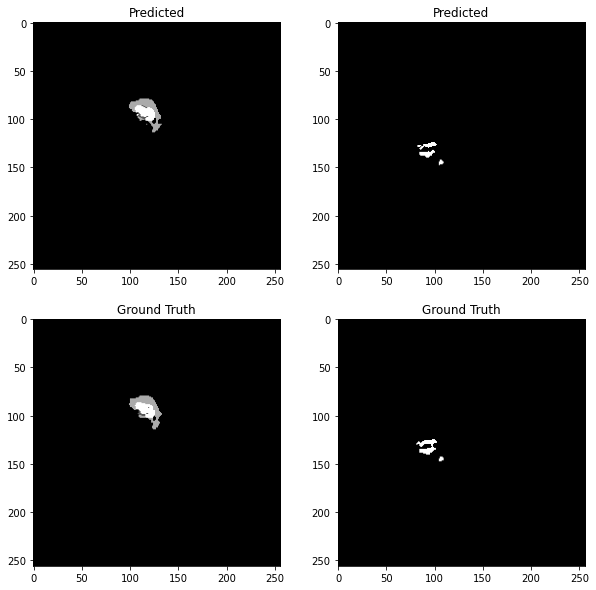

100%|██████████| 3971/3971 [33:42<00:00,  1.96it/s]



Average Training Loss: 0.002733490308448841

Average Training DSC: [0.99961095 0.9383471  0.96151049 0.91739405]
Average Training ASSD: [0.04747039 6.55003192 1.95609924 6.77254378]


  0%|          | 0/993 [00:00<?, ?it/s]

Validation Prediction Visualization:


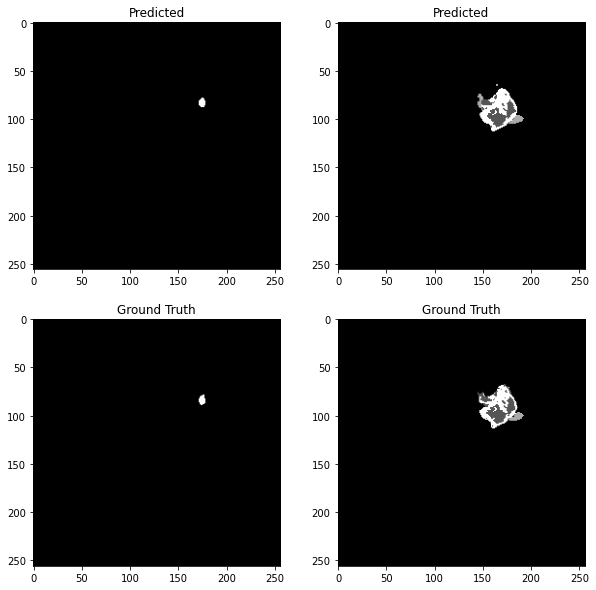

100%|██████████| 993/993 [05:40<00:00,  2.92it/s]


Average Validation Loss: 0.007103135214681471

Average Validation DSC: [0.99934116 0.91087844 0.91433157 0.86005137]
Average Validation ASSD: [ 0.09098195 11.99762036 12.01080662  8.06322412]
Epoch 43/50
-------------------------


  0%|          | 0/3971 [00:00<?, ?it/s]

Training Prediction Visualization:


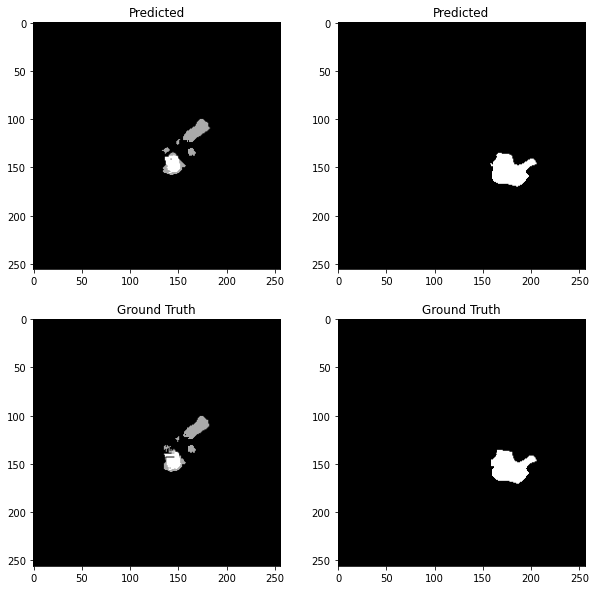

100%|██████████| 3971/3971 [34:06<00:00,  1.94it/s]



Average Training Loss: 0.0027551413251338487

Average Training DSC: [0.99961012 0.93793908 0.96085536 0.91743659]
Average Training ASSD: [0.04730408 6.66523888 2.15735711 6.35420856]


  0%|          | 0/993 [00:00<?, ?it/s]

Validation Prediction Visualization:


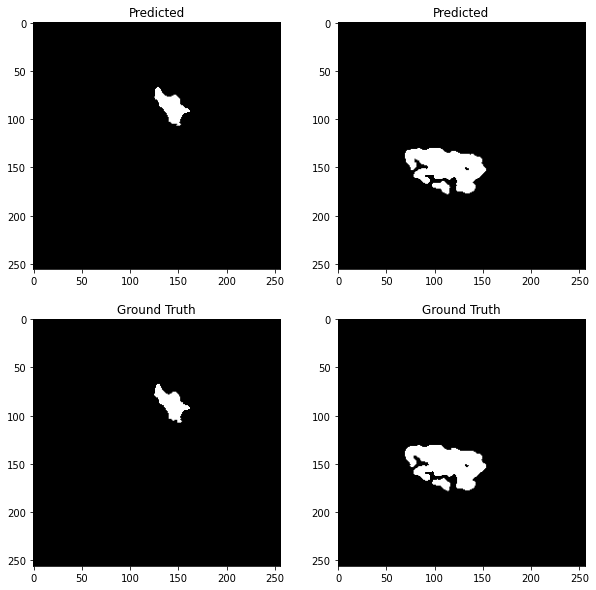

100%|██████████| 993/993 [05:33<00:00,  2.97it/s]


Average Validation Loss: 0.006830749075675959

Average Validation DSC: [0.99935399 0.91159405 0.91224    0.86345761]
Average Validation ASSD: [ 0.0878832  11.85654437 12.65781616  7.80606114]
Epoch 44/50
-------------------------


  0%|          | 0/3971 [00:00<?, ?it/s]

Training Prediction Visualization:


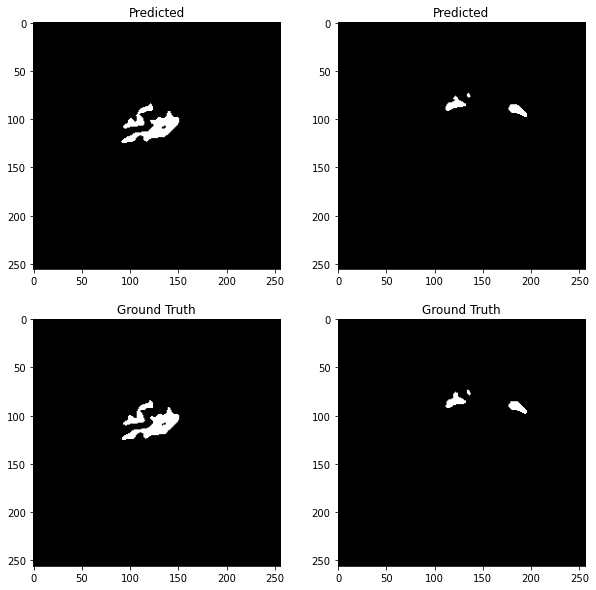

100%|██████████| 3971/3971 [33:57<00:00,  1.95it/s]



Average Training Loss: 0.0025713265276551753

Average Training DSC: [0.9996337  0.94044655 0.96484332 0.92167421]
Average Training ASSD: [0.04404224 6.29632688 1.43552669 6.24905919]


  0%|          | 0/993 [00:00<?, ?it/s]

Validation Prediction Visualization:


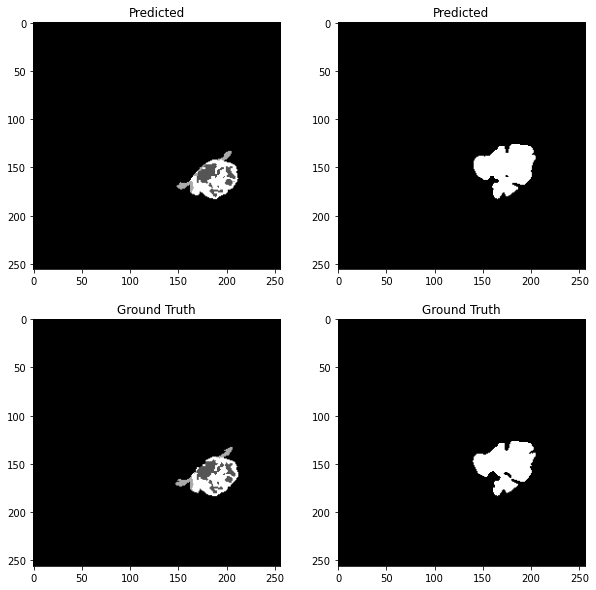

100%|██████████| 993/993 [05:39<00:00,  2.93it/s]


Average Validation Loss: 0.007212983602132697

Average Validation DSC: [0.99935041 0.90990198 0.91849042 0.8659438 ]
Average Validation ASSD: [ 0.08935164 12.09725093 10.64871275  5.71278031]
Epoch 45/50
-------------------------


  0%|          | 0/3971 [00:00<?, ?it/s]

Training Prediction Visualization:


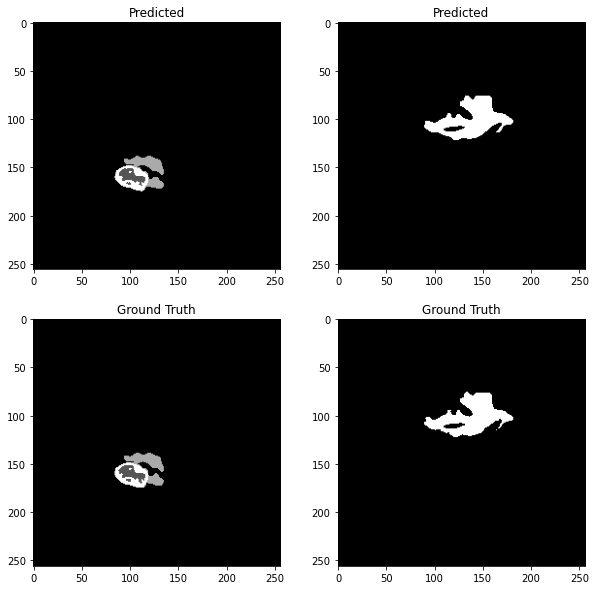

100%|██████████| 3971/3971 [34:32<00:00,  1.92it/s]



Average Training Loss: 0.0026031268248228987

Average Training DSC: [0.9996297  0.94003851 0.96426767 0.92157172]
Average Training ASSD: [0.04422553 6.3781246  1.539621   6.09775725]


  0%|          | 0/993 [00:00<?, ?it/s]

Validation Prediction Visualization:


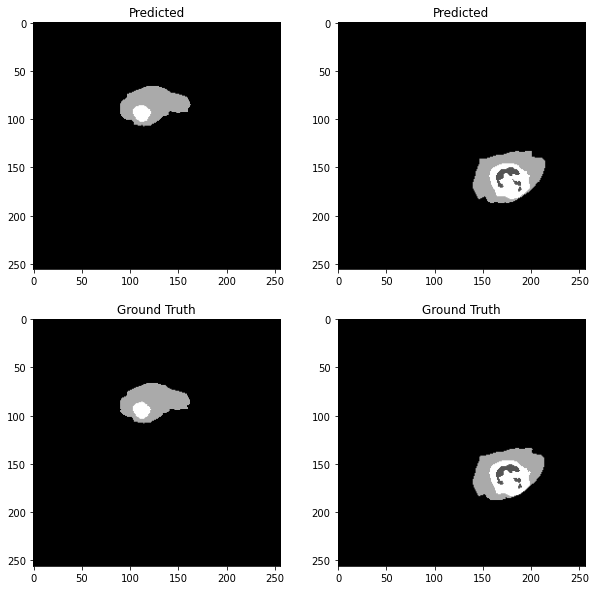

100%|██████████| 993/993 [05:39<00:00,  2.92it/s]


Average Validation Loss: 0.007085002753377141

Average Validation DSC: [0.99935053 0.91083676 0.91517249 0.86176523]
Average Validation ASSD: [ 0.08916808 12.20561655 11.98232931  8.30202899]
Epoch 46/50
-------------------------


  0%|          | 0/3971 [00:00<?, ?it/s]

Training Prediction Visualization:


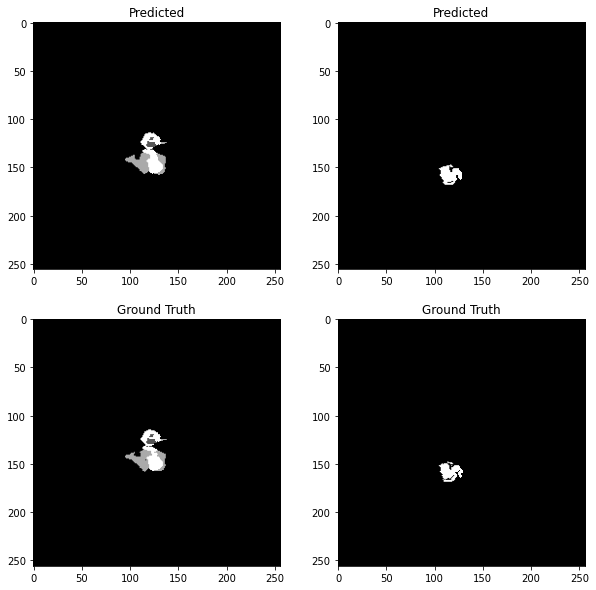

100%|██████████| 3971/3971 [34:07<00:00,  1.94it/s]



Average Training Loss: 0.0025026425785955922

Average Training DSC: [0.99964312 0.94198787 0.96547856 0.92385139]
Average Training ASSD: [0.04271959 5.97327611 1.50422686 6.14925364]


  0%|          | 0/993 [00:00<?, ?it/s]

Validation Prediction Visualization:


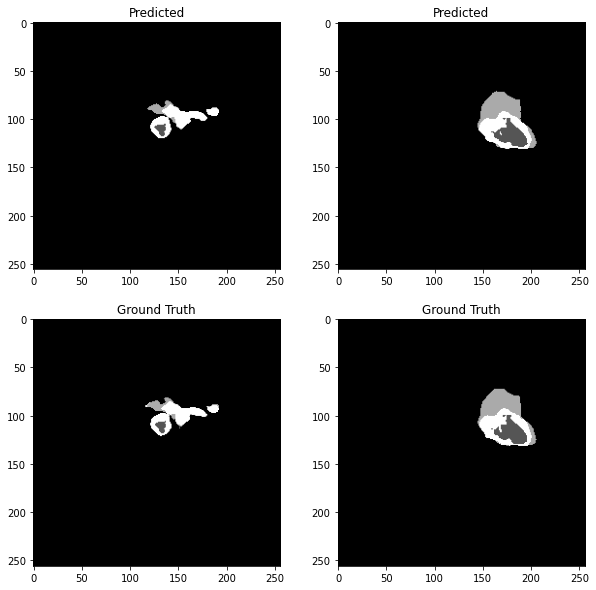

100%|██████████| 993/993 [05:41<00:00,  2.91it/s]


Average Validation Loss: 0.007183817530863085

Average Validation DSC: [0.99932765 0.91184832 0.9158061  0.86489471]
Average Validation ASSD: [ 0.09352114 11.80793682 11.73748684  5.57889707]
Epoch 47/50
-------------------------


  0%|          | 0/3971 [00:00<?, ?it/s]

Training Prediction Visualization:


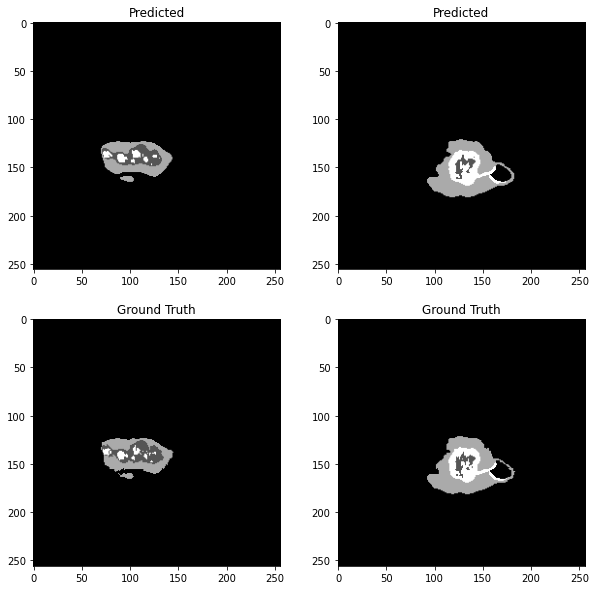

100%|██████████| 3971/3971 [34:34<00:00,  1.91it/s]



Average Training Loss: 0.002445184153310478

Average Training DSC: [0.99964919 0.94243523 0.9663013  0.92535788]
Average Training ASSD: [0.04177975 5.85022449 1.33579295 5.69458823]


  0%|          | 0/993 [00:00<?, ?it/s]

Validation Prediction Visualization:


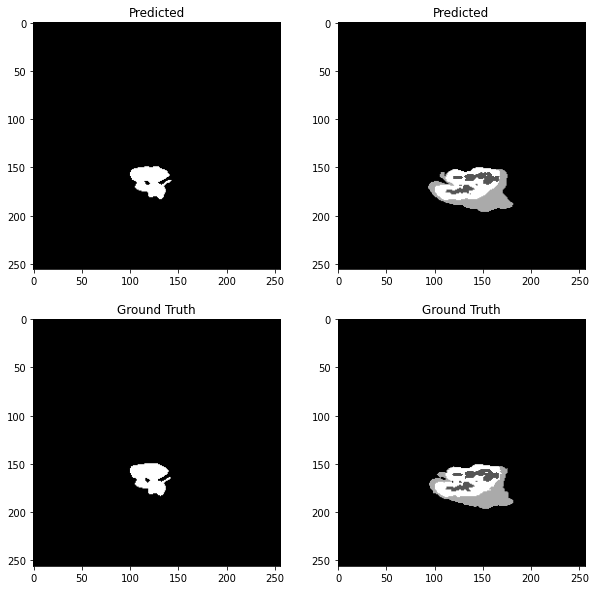

100%|██████████| 993/993 [05:45<00:00,  2.88it/s]


Average Validation Loss: 0.007081662043263199

Average Validation DSC: [0.99935261 0.90938459 0.91552792 0.86318029]
Average Validation ASSD: [ 0.08986923 12.16685924 11.47559346  7.14483849]
Epoch 48/50
-------------------------


  0%|          | 0/3971 [00:00<?, ?it/s]

Training Prediction Visualization:


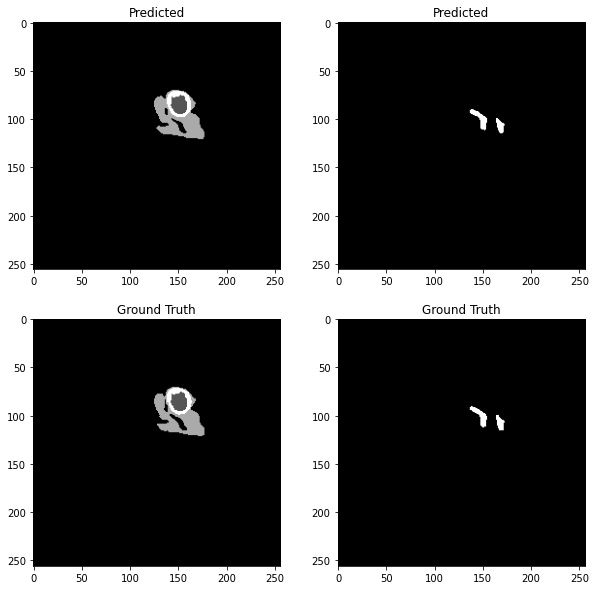

100%|██████████| 3971/3971 [34:35<00:00,  1.91it/s]



Average Training Loss: 0.002403700132493105

Average Training DSC: [0.99965533 0.94303958 0.96672707 0.92616147]
Average Training ASSD: [0.04099116 5.7371735  1.36002399 5.74690271]


  0%|          | 0/993 [00:00<?, ?it/s]

Validation Prediction Visualization:


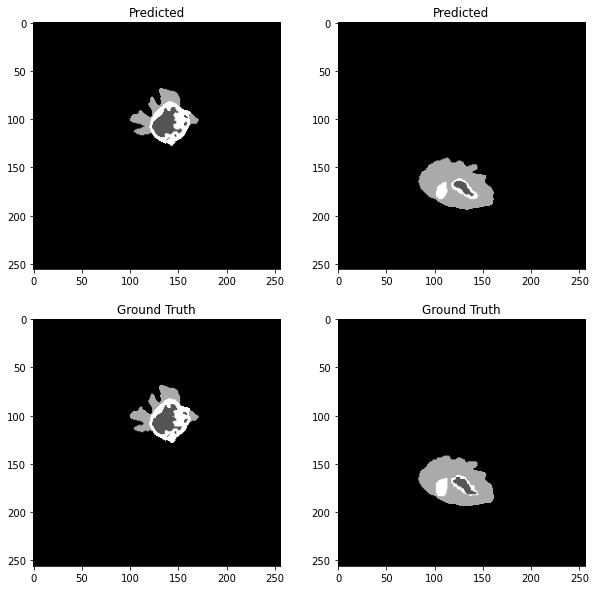

100%|██████████| 993/993 [05:47<00:00,  2.86it/s]


Average Validation Loss: 0.0075289275352294445

Average Validation DSC: [0.99935591 0.91066606 0.91710382 0.86581087]
Average Validation ASSD: [ 0.0883054  12.22767064 10.90104092  6.14855275]
Epoch 49/50
-------------------------


  0%|          | 0/3971 [00:00<?, ?it/s]

Training Prediction Visualization:


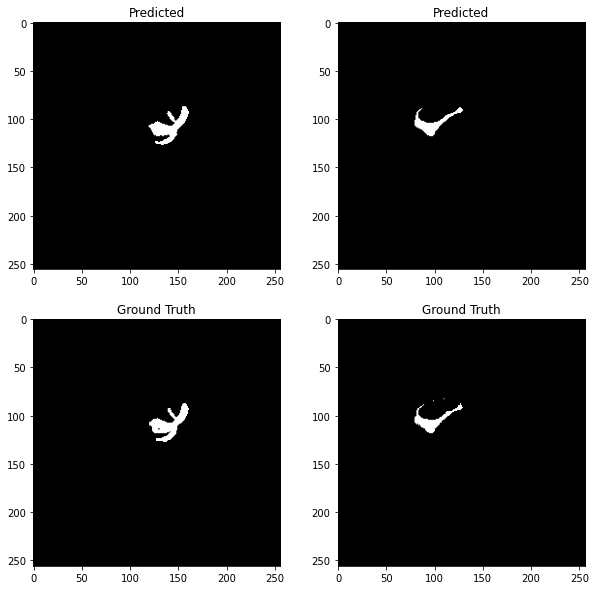

100%|██████████| 3971/3971 [34:15<00:00,  1.93it/s]



Average Training Loss: 0.0024087997182131423

Average Training DSC: [0.99965743 0.94325005 0.96652107 0.92677828]
Average Training ASSD: [0.04070761 5.80365492 1.43746671 5.50186681]


  0%|          | 0/993 [00:00<?, ?it/s]

Validation Prediction Visualization:


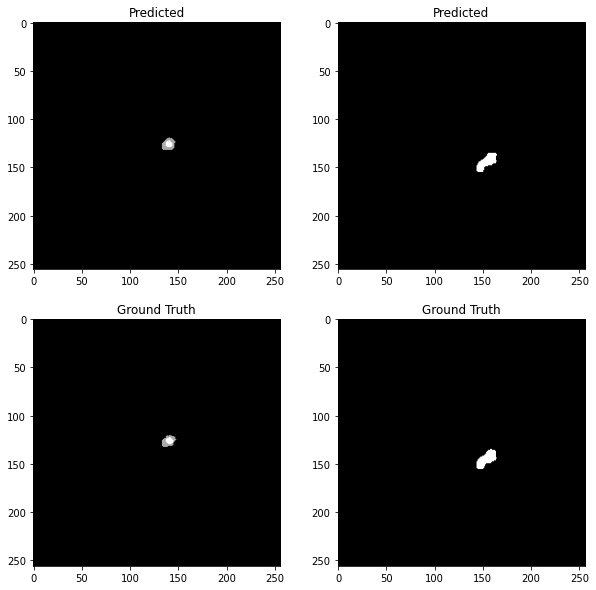

100%|██████████| 993/993 [05:47<00:00,  2.86it/s]


Average Validation Loss: 0.00735058147771601

Average Validation DSC: [0.99935924 0.91085056 0.91785194 0.86504307]
Average Validation ASSD: [ 0.08912217 11.63946164 11.28278056  5.97665389]
Epoch 50/50
-------------------------


  0%|          | 0/3971 [00:00<?, ?it/s]

Training Prediction Visualization:


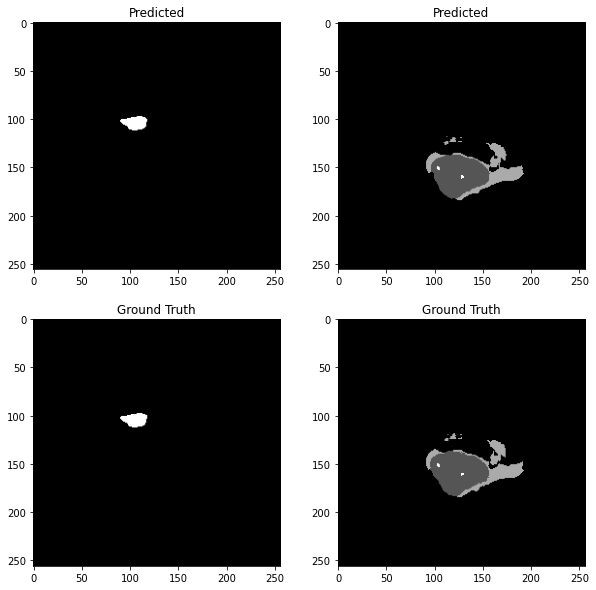

100%|██████████| 3971/3971 [34:41<00:00,  1.91it/s]



Average Training Loss: 0.0023431667860855827

Average Training DSC: [0.99966671 0.94444482 0.96762017 0.9279897 ]
Average Training ASSD: [0.03960128 5.63510771 1.31060878 5.69469755]


  0%|          | 0/993 [00:00<?, ?it/s]

Validation Prediction Visualization:


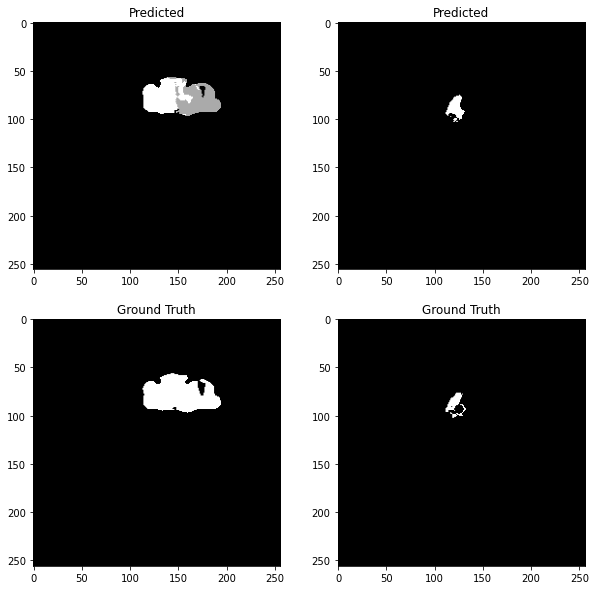

100%|██████████| 993/993 [05:45<00:00,  2.87it/s]

Average Validation Loss: 0.007513231691395093

Average Validation DSC: [0.99936095 0.91139718 0.91613057 0.86452132]
Average Validation ASSD: [ 0.08799124 11.70602692 11.44766237  7.17708671]


In [11]:
model = train_model(num_epochs = 50)